In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import Toronto major crime indicators (MCI)
- About and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about 

- Other crimes:
    - homicide csv https://data.torontopolice.on.ca/datasets/TorontoPS::homicide-asr-rc-tbl-002/explore?location=43.721941%2C-79.371145%2C11.78&showTable=true
    - shootings csv https://data.torontopolice.on.ca/datasets/TorontoPS::shootings-and-firearm-discharges/explore?location=21.919150%2C-39.812750%2C4.69&showTable=true
    - Theft from motor vehicle https://data.torontopolice.on.ca/datasets/TorontoPS::theft-from-motor-vehicle/explore?location=22.246462%2C-39.965802%2C4.69&showTable=true
        - theft over 5,000 is already included in MCI as 'thefy over'
    - bicycle theft https://data.torontopolice.on.ca/datasets/TorontoPS::bicycle-thefts/explore?location=21.520237%2C-39.911850%2C4.53&showTable=true


In [4]:
mci_df = pd.read_csv('../data/raw/Major_Crime_Indicators.csv')
mci_df.drop(columns = ['premises_type', 'x', 'y'], inplace = True)
mci_df

C:\Users\willi\AppData\Local\Temp\ipykernel_32296\850645381.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_df = pd.read_csv('../data/raw/Major_Crime_Indicators.csv')


,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,occurrence_hour,MCI,hood_id,neighbourhood,longitude,latitude
0,GO-20141625305,2/3/2014 13:00,2014,March,2,61,Sunday,8,Assault,1,West Humber-Clairville,-79.590332,43.734013
1,GO-20141272968,24/12/2013 13:00,2013,December,24,358,Tuesday,22,Robbery,1,West Humber-Clairville,-79.600701,43.731834
2,GO-20141284361,5/1/2013 13:00,2013,January,5,5,Saturday,4,Assault,1,West Humber-Clairville,-79.600794,43.686423
3,GO-20141292177,31/12/2013 13:00,2013,December,31,365,Tuesday,21,Break and Enter,1,West Humber-Clairville,-79.603876,43.743642
4,GO-20141297201,3/1/2014 13:00,2014,January,3,3,Friday,10,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281687,GO-20211875584,30/9/2021 12:00,2021,September,30,273,Thursday,4,Break and Enter,NSA,NSA,0.000000,0.000000
281688,GO-20211878198,30/9/2021 12:00,2021,September,30,273,Thursday,14,Robbery,NSA,NSA,0.000000,0.000000
281689,GO-20211884903,1/10/2021 12:00,2021,October,1,274,Friday,12,Assault,NSA,NSA,-79.879105,43.497480
281690,GO-20211885958,1/1/2019 13:00,2019,January,1,1,Tuesday,0,Assault,NSA,NSA,-79.766321,43.698093


## drop duplicates

In [12]:
mci_df[mci_df.duplicated(keep=False)].sort_values(by = 'occurrence_unique_id')

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,occurrence_hour,MCI,hood_id,neighbourhood,longitude,latitude
253590,GO-20141150249,1/1/1995 13:00,0,NaN,0,0,NaN,12,Assault,131,Rouge,-79.230100,43.823032
253593,GO-20141150249,1/1/1995 13:00,0,NaN,0,0,NaN,12,Assault,131,Rouge,-79.230100,43.823032
148466,GO-20141259762,31/12/2013 13:00,2013,December,31,365,Tuesday,23,Assault,77,Waterfront Communities-The Island,-79.390756,43.649131
148467,GO-20141259762,31/12/2013 13:00,2013,December,31,365,Tuesday,23,Assault,77,Waterfront Communities-The Island,-79.390756,43.649131
107735,GO-20141259834,1/1/2014 13:00,2014,January,1,1,Wednesday,0,Assault,55,Thorncliffe Park,-79.346588,43.703212
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280149,GO-2021999374,29/5/2021 12:00,2021,May,29,149,Saturday,20,Assault,NSA,NSA,0.000000,0.000000
280150,GO-2021999374,29/5/2021 12:00,2021,May,29,149,Saturday,20,Assault,NSA,NSA,0.000000,0.000000
129763,GO-2021999725,29/5/2021 12:00,2021,May,29,149,Saturday,21,Assault,74,North St.James Town,-79.373738,43.667295
129762,GO-2021999725,29/5/2021 12:00,2021,May,29,149,Saturday,21,Assault,74,North St.James Town,-79.373738,43.667295


In [14]:
mci_df.drop_duplicates(keep = 'first', inplace = True)

In [22]:
mci_df.shape

(249029, 13)

In [181]:
mci_df.columns

Index(['occurrence_unique_id', 'occurrence_date', 'occurrence_year',
       'occurrence_month', 'occurrence_day', 'occurrence_dayofyear',
       'occurrence_dayofweek', 'occurrence_hour', 'MCI', 'hood_id',
       'neighbourhood', 'longitude', 'latitude'],
      dtype='object')

## Add data for shootings and homicide

In [15]:
# read and clean shootings data
shootings = pd.read_csv('../data/raw/Shootings.csv')
shootings.drop(columns=['time_range', 'death', 'injuries', 'index', 'division', 'object_id', 'x', 'y'], inplace=True)
shootings['neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in shootings['neighbourhood']]
shootings['MCI'] = 'Shootings'

In [16]:
shootings[shootings.duplicated(keep=False)].sort_values(by = 'occurrence_unique_id')

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_dayofweek,occurrence_hour,hood_id,neighbourhood,longitude,latitude,MCI


In [183]:
shootings.shape

(5328, 11)

In [18]:
# read and clean homicides data
homicide = pd.read_csv('../data/raw/Homicide.csv')
homicide.drop(columns=['homicide_type', 'index', 'division', 'object_id', 'x', 'y'], inplace=True)
homicide['neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in homicide['neighbourhood']]
homicide['MCI'] = 'Homicide'

In [19]:
homicide[homicide.duplicated(keep=False)].sort_values(by = 'occurrence_unique_id')

,occurrence_unique_id,occurrence_year,occurrence_date,hood_id,neighbourhood,longitude,latitude,MCI
1155,1068304,2005,2005-08-07 12:00:00,71,Cabbagetown-South St.James Town,-79.375480,43.665741,Homicide
1156,1068304,2005,2005-08-07 12:00:00,71,Cabbagetown-South St.James Town,-79.375480,43.665741,Homicide
1173,1156513,2005,2005-09-16 12:00:00,5,Elms-Old Rexdale,-79.549325,43.727291,Homicide
1172,1156513,2005,2005-09-16 12:00:00,5,Elms-Old Rexdale,-79.549325,43.727291,Homicide
1171,1156513,2005,2005-09-16 12:00:00,5,Elms-Old Rexdale,-79.549325,43.727291,Homicide
...,...,...,...,...,...,...,...,...
517,GO-20211107853,2021,2021-06-13 12:00:00,138,Eglinton East,-79.244525,43.744141,Homicide
537,GO-20211494943,2021,2021-08-08 12:00:00,78,Kensington-Chinatown,-79.399276,43.656102,Homicide
536,GO-20211494943,2021,2021-08-08 12:00:00,78,Kensington-Chinatown,-79.399276,43.656102,Homicide
547,GO-20211699665,2021,2021-09-05 12:00:00,140,Guildwood,-79.210399,43.750125,Homicide


In [20]:
homicide.drop_duplicates(keep = 'first', inplace = True)

In [21]:
homicide.shape

(1173, 8)

In [23]:
# check columns are in the same order
pd.concat([mci_df.loc[0], shootings.loc[0], homicide.loc[0]], axis=1).T

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,occurrence_hour,MCI,hood_id,neighbourhood,longitude,latitude
0,GO-20141625305,2/3/2014 13:00,2014,March,2,61,Sunday,8,Assault,1,West Humber-Clairville,-79.590332,43.734013
0,GO-2004510813,2004-06-19 12:00:00,2004,June,NaN,NaN,Saturday,17.0,Shootings,23,Pelmo Park-Humberlea,-79.53608,43.71103
0,GO-20192106976,2019-10-31 12:00:00,2019,NaN,NaN,NaN,NaN,NaN,Homicide,95,Annex,-79.404148,43.667464


In [24]:
mci_df = pd.concat([mci_df, shootings, homicide], axis=0).reset_index(drop=True)

## Missing data

In [25]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0].sort_values(ascending=False)

Columns with missing data


occurrence_day          6501
occurrence_dayofyear    6501
occurrence_month        1249
occurrence_dayofweek    1249
occurrence_hour         1174
occurrence_date            3
dtype: int64

In [26]:
# print rows with missing data
na_index = mci_df.loc[mci_df.isna().any(axis=1)].index
mci_df.loc[na_index]

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,occurrence_hour,MCI,hood_id,neighbourhood,longitude,latitude
1419,GO-20181572613,1/1/1995 13:00,0,NaN,0.0,0.0,NaN,9.0,Assault,1,West Humber-Clairville,-79.614235,43.732190
14320,GO-2019461576,1/1/1999 13:00,0,NaN,0.0,0.0,NaN,0.0,Assault,7,Willowridge-Martingrove-Richview,-79.564180,43.676839
15529,GO-20151804633,1/1/1996 13:00,0,NaN,0.0,0.0,NaN,8.0,Assault,8,Humber Heights-Westmount,-79.527375,43.684156
17283,GO-20201870404,1/1/1980 13:00,0,NaN,0.0,0.0,NaN,12.0,Assault,9,Edenbridge-Humber Valley,-79.512447,43.685515
20573,GO-2015636294,NaN,0,NaN,0.0,0.0,NaN,0.0,Assault,14,Islington-City Centre West,-79.530779,43.643038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255525,1905589,2006-10-09 12:00:00,2006,NaN,NaN,NaN,NaN,NaN,Homicide,43,Victoria Village,-79.304428,43.718907
255526,1696286,2006-10-17 12:00:00,2006,NaN,NaN,NaN,NaN,NaN,Homicide,119,Wexford/Maryvale,-79.300444,43.727942
255527,1603174,2006-10-21 12:00:00,2006,NaN,NaN,NaN,NaN,NaN,Homicide,135,Morningside,-79.194315,43.789276
255528,1877732,2006-10-27 12:00:00,2006,NaN,NaN,NaN,NaN,NaN,Homicide,16,Stonegate-Queensway,-79.496230,43.627735


In [27]:
281692+5328+1252

288272

### load neighbourhood boundaries

In [28]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson', driver='GeoJSON')

### fill na with occurence dates

In [29]:
# we can use occurencedate to fill these na values
mci_df['occurrence_date'] = pd.to_datetime(mci_df['occurrence_date'])

In [30]:
# let's see if we can imply the NA columns with the date column
# All okay except the hour column
# crimes should happen across the day but not only within 12:00 and 13:00
check_dates = pd.concat([
    mci_df['occurrence_date'].dt.day.describe(),
    mci_df['occurrence_date'].dt.dayofyear.describe(),
    mci_df['occurrence_date'].dt.month.describe(),
    mci_df['occurrence_date'].dt.weekday.describe(),
    mci_df['occurrence_date'].dt.hour.describe()
    ],
          axis=1)
check_dates.columns = ['dayofmonth', 'dayofyear', 'month', 'weekday', 'hour']
check_dates

,dayofmonth,dayofyear,month,weekday,hour
count,255527.000000,255527.000000,255527.000000,255527.000000,255527.000000
mean,15.629162,182.514478,6.506048,3.029539,12.336332
std,8.738727,106.221476,3.464220,1.993419,0.472455
min,1.000000,1.000000,1.000000,0.000000,12.000000
25%,8.000000,91.000000,4.000000,1.000000,12.000000
50%,16.000000,185.000000,7.000000,3.000000,12.000000
75%,23.000000,274.000000,10.000000,5.000000,13.000000
max,31.000000,366.000000,12.000000,6.000000,13.000000


In [31]:
# If we cannot imply missing hour from date, can we drop the rows with missing occurrence_hour instead?
# No
# Among those records with NA in occurrence_hour, there are 1,252 records linked to homicide
# that's almost 25% of all the homicide records
# therefore, we should not drop these rows
mci_df[mci_df['occurrence_hour'].isna()].groupby('MCI').size()

MCI
Homicide     1173
Shootings       1
dtype: int64

In [194]:
# instead, let's not use the column for occurrence_hour
mci_df.drop(columns=['occurrence_hour'], inplace=True)

In [195]:
def fix_na(col, series_replace):
    return np.where(mci_df[col].isna(), 
                    series_replace, # replace na with this value
                    mci_df[col])    # keep the non-na values

mci_df['occurrence_year'] = fix_na('occurrence_year',
                                  mci_df['occurrence_date'].dt.year.astype(float))
mci_df['occurrence_month'] = fix_na('occurrence_month',
                                   mci_df['occurrence_date'].dt.strftime("%B"))
mci_df['occurrence_day'] = fix_na('occurrence_day',
                                 mci_df['occurrence_date'].dt.day.astype(float))
mci_df['occurrence_dayofyear'] = fix_na('occurrence_dayofyear',
                                       mci_df['occurrence_date'].dt.dayofyear.astype(float))
mci_df['occurrence_dayofweek'] = fix_na('occurrence_dayofweek',
                                       mci_df['occurrence_date'].dt.strftime("%A"))

# rows with missing data are now filled with the correct entries
mci_df.loc[na_index]

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,MCI,hood_id,neighbourhood,longitude,latitude
1609,GO-20181572613,1995-01-01 13:00:00,0.0,January,0.0,0.0,Sunday,Assault,1,West Humber-Clairville,-79.614235,43.732190
16184,GO-2019461576,1999-01-01 13:00:00,0.0,January,0.0,0.0,Friday,Assault,7,Willowridge-Martingrove-Richview,-79.564180,43.676839
16887,GO-2019461576,1999-01-01 13:00:00,0.0,January,0.0,0.0,Friday,Assault,7,Willowridge-Martingrove-Richview,-79.564180,43.676839
17480,GO-20151804633,1996-01-01 13:00:00,0.0,January,0.0,0.0,Monday,Assault,8,Humber Heights-Westmount,-79.527375,43.684156
19381,GO-20201870404,1980-01-01 13:00:00,0.0,January,0.0,0.0,Tuesday,Assault,9,Edenbridge-Humber Valley,-79.512447,43.685515
...,...,...,...,...,...,...,...,...,...,...,...,...
288267,1905589,2006-10-09 12:00:00,2006.0,October,9.0,282.0,Monday,Homicide,43,Victoria Village,-79.304428,43.718907
288268,1696286,2006-10-17 12:00:00,2006.0,October,17.0,290.0,Tuesday,Homicide,119,Wexford/Maryvale,-79.300444,43.727942
288269,1603174,2006-10-21 12:00:00,2006.0,October,21.0,294.0,Saturday,Homicide,135,Morningside,-79.194315,43.789276
288270,1877732,2006-10-27 12:00:00,2006.0,October,27.0,300.0,Friday,Homicide,16,Stonegate-Queensway,-79.496230,43.627735


In [196]:
print("Columns with missing data after filling na")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after filling na


occurrence_date         3
occurrence_month        3
occurrence_dayofweek    3
dtype: int64

In [197]:
# let's drop these rows with missing occurrence_date
mci_df[mci_df.occurrence_date.isna() != 0]

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,MCI,hood_id,neighbourhood,longitude,latitude
22978,GO-2015636294,NaT,0.0,NaN,0.0,0.0,NaN,Assault,14,Islington-City Centre West,-79.530779,43.643038
207153,GO-20143212768,NaT,0.0,NaN,0.0,0.0,NaN,Assault,107,Oakwood Village,-79.446782,43.687272
277185,GO-20142269218,NaT,0.0,NaN,0.0,0.0,NaN,Assault,NSA,NSA,0.000000,0.000000


In [198]:
mci_df.dropna(subset=['occurrence_date'], inplace=True)

In [199]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Checking for date inconsistencies

In [200]:
# is the year, month, day etc. consistent with the date column?
print(sum(mci_df.occurrence_date.dt.year != mci_df.occurrence_year))
print(sum(mci_df.occurrence_date.dt.strftime("%B") != mci_df.occurrence_month))
print(sum(mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day))
print(sum(mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear))
print(sum(mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek))

92
0
92
92
281597


### inconsistency in year

In [201]:
# Inconsistency in year column
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year, ['occurrence_date', 'occurrence_year']]

,occurrence_date,occurrence_year
1609,1995-01-01 13:00:00,0.0
16184,1999-01-01 13:00:00,0.0
16887,1999-01-01 13:00:00,0.0
17480,1996-01-01 13:00:00,0.0
19381,1980-01-01 13:00:00,0.0
...,...,...
279606,1972-01-01 13:00:00,0.0
279789,1984-01-01 13:00:00,0.0
279875,1989-09-11 12:00:00,0.0
280072,1979-12-25 13:00:00,0.0


In [202]:
# all of the inconsistent records have year 0
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year]['occurrence_year'].unique()

array([0.])

In [203]:
# replace with correct year
mci_df.loc[mci_df.occurrence_date.dt.year != mci_df.occurrence_year, 'occurrence_year'] = mci_df[mci_df.occurrence_date.dt.year != mci_df.occurrence_year].occurrence_date.dt.year

### inconsistency in day of month

In [204]:
# Inconsistency in day column
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day, ['occurrence_date', 'occurrence_day']]

,occurrence_date,occurrence_day
1609,1995-01-01 13:00:00,0.0
16184,1999-01-01 13:00:00,0.0
16887,1999-01-01 13:00:00,0.0
17480,1996-01-01 13:00:00,0.0
19381,1980-01-01 13:00:00,0.0
...,...,...
279606,1972-01-01 13:00:00,0.0
279789,1984-01-01 13:00:00,0.0
279875,1989-09-11 12:00:00,0.0
280072,1979-12-25 13:00:00,0.0


In [205]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day]['occurrence_day'].unique()

array([0.])

In [206]:
# replace with correct day
mci_df.loc[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day, 'occurrence_day'] = mci_df[mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day].occurrence_date.dt.day.astype(float)

### inconsistency in day of year

In [207]:
# Inconsistency in day of year column
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear, ['occurrence_date', 'occurrence_dayofyear']]

,occurrence_date,occurrence_dayofyear
1609,1995-01-01 13:00:00,0.0
16184,1999-01-01 13:00:00,0.0
16887,1999-01-01 13:00:00,0.0
17480,1996-01-01 13:00:00,0.0
19381,1980-01-01 13:00:00,0.0
...,...,...
279606,1972-01-01 13:00:00,0.0
279789,1984-01-01 13:00:00,0.0
279875,1989-09-11 12:00:00,0.0
280072,1979-12-25 13:00:00,0.0


In [208]:
# all inconsistent records are 0
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear]['occurrence_dayofyear'].unique()

array([0.])

In [209]:
# replace with correct day of year
mci_df.loc[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear, 'occurrence_dayofyear'] = mci_df[mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear].occurrence_date.dt.dayofyear.astype(float)

### inconsistency in day of week

In [210]:
# Inconsistency in day of week column
# data looks correct but why is it showing inconsistency?
mci_df.loc[mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek, ['occurrence_date', 'occurrence_dayofweek']]

,occurrence_date,occurrence_dayofweek
0,2014-03-02 13:00:00,Sunday
1,2013-12-24 13:00:00,Tuesday
2,2013-01-05 13:00:00,Saturday
3,2013-12-31 13:00:00,Tuesday
4,2014-01-03 13:00:00,Friday
...,...,...
281687,2021-09-30 12:00:00,Thursday
281688,2021-09-30 12:00:00,Thursday
281689,2021-10-01 12:00:00,Friday
281690,2019-01-01 13:00:00,Tuesday


In [211]:
# inconsistency due to white space in this column
mci_df.occurrence_dayofweek.unique()

array(['Sunday    ', 'Tuesday   ', 'Saturday  ', 'Friday    ',
       'Wednesday ', 'Monday    ', 'Thursday  ', 'Sunday', 'Friday',
       'Monday', 'Tuesday', 'Thursday', 'Saturday', 'Wednesday'],
      dtype=object)

In [212]:
mci_df.occurrence_dayofweek = [x.strip() for x in mci_df.occurrence_dayofweek]

In [213]:
# Now all columns are consistent with occurrence_date
print(sum(mci_df.occurrence_date.dt.year != mci_df.occurrence_year))
print(sum(mci_df.occurrence_date.dt.strftime("%B") != mci_df.occurrence_month))
print(sum(mci_df.occurrence_date.dt.day.astype(float) != mci_df.occurrence_day))
print(sum(mci_df.occurrence_date.dt.dayofyear.astype(float) != mci_df.occurrence_dayofyear))
print(sum(mci_df.occurrence_date.dt.strftime("%A") != mci_df.occurrence_dayofweek))

0
0
0
0
0


### inconsistency in hood_ID and neighbourhood

In [214]:
# check if hood_id and neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(mci_df.hood_id.unique()), len(mci_df.neighbourhood.unique()))

278 144


In [215]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [216]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')[:2].values

array([[129, 'Agincourt North', 1484],
       ['129', 'Agincourt North', 10]], dtype=object)

In [217]:
mci_df['hood_id'] = mci_df['hood_id'].astype(str)

In [218]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')

In [219]:
# let's check with neighbourhood refers to hood_id = 3
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

,hood_id,neighbourhood,counts


In [220]:
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
# duplicate in hood_id
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

,hood_id,neighbourhood,counts
20,117,L'Amoreaux,112
21,117,LAmoreaux,2461
22,118,Tam O'Shanter-Sullivan,41
23,118,Tam OShanter-Sullivan,1808
92,54,O'Connor-Parkview,73
93,54,OConnor-Parkview,1804


In [221]:
# fix duplicate neighbourhood
mci_df.loc[(mci_df.hood_id == '117') & (mci_df.neighbourhood == 'LAmoreaux'), 'neighbourhood'] = "L'Amoreaux"
mci_df.loc[(mci_df.hood_id == '118') & (mci_df.neighbourhood == 'Tam OShanter-Sullivan'), 'neighbourhood'] = "Tam O'Shanter-Sullivan"
mci_df.loc[(mci_df.hood_id == '54') & (mci_df.neighbourhood == 'OConnor-Parkview'), 'neighbourhood'] = "O'Connor-Parkview"

In [222]:
# hood_id and neighbourhood are now 1-to-1
check_duplicate = mci_df.groupby(['hood_id','neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

,hood_id,neighbourhood,counts


In [223]:
check_duplicate[check_duplicate.duplicated(subset='neighbourhood', keep=False)].sort_values(by='neighbourhood')

,hood_id,neighbourhood,counts


### inconsistency vs neighbourhood boundary

In [224]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], mci_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

,neighbourhood_x,hood_id,neighbourhood_y
5880546,Mimico (includes Humber Bay Shores),17,Mimico


In [225]:
mci_df.loc[(mci_df.hood_id == '17') & (mci_df.neighbourhood == 'Mimico'), 'neighbourhood'] = "Mimico (includes Humber Bay Shores)"

In [226]:
merge_df = pd.merge(neighbourhoods[['neighbourhood', 'hood_id']], mci_df[['hood_id', 'neighbourhood']], on=['hood_id'])
merge_df[merge_df['neighbourhood_x'] != merge_df['neighbourhood_y']].drop_duplicates(subset=['neighbourhood_x'])

,neighbourhood_x,hood_id,neighbourhood_y


### add quarter column

In [228]:
mci_df['occurrence_quarter'] = mci_df.occurrence_date.dt.quarter

## Fixing Dtypes

In [229]:
mci_df.dtypes

occurrence_unique_id            object
occurrence_date         datetime64[ns]
occurrence_year                float64
occurrence_month                object
occurrence_day                 float64
occurrence_dayofyear           float64
occurrence_dayofweek            object
MCI                             object
hood_id                         object
neighbourhood                   object
longitude                      float64
latitude                       float64
occurrence_quarter               int64
dtype: object

In [230]:
# 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear' should not be of type float
mci_df.columns[mci_df.dtypes == float]

Index(['occurrence_year', 'occurrence_day', 'occurrence_dayofyear',
       'longitude', 'latitude'],
      dtype='object')

In [231]:
for x in ['occurrence_year', 'occurrence_day', 'occurrence_dayofyear']:
    mci_df[x] = mci_df[x].astype(int)

## Imputing missing longitude and latitude

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>]], dtype=object)

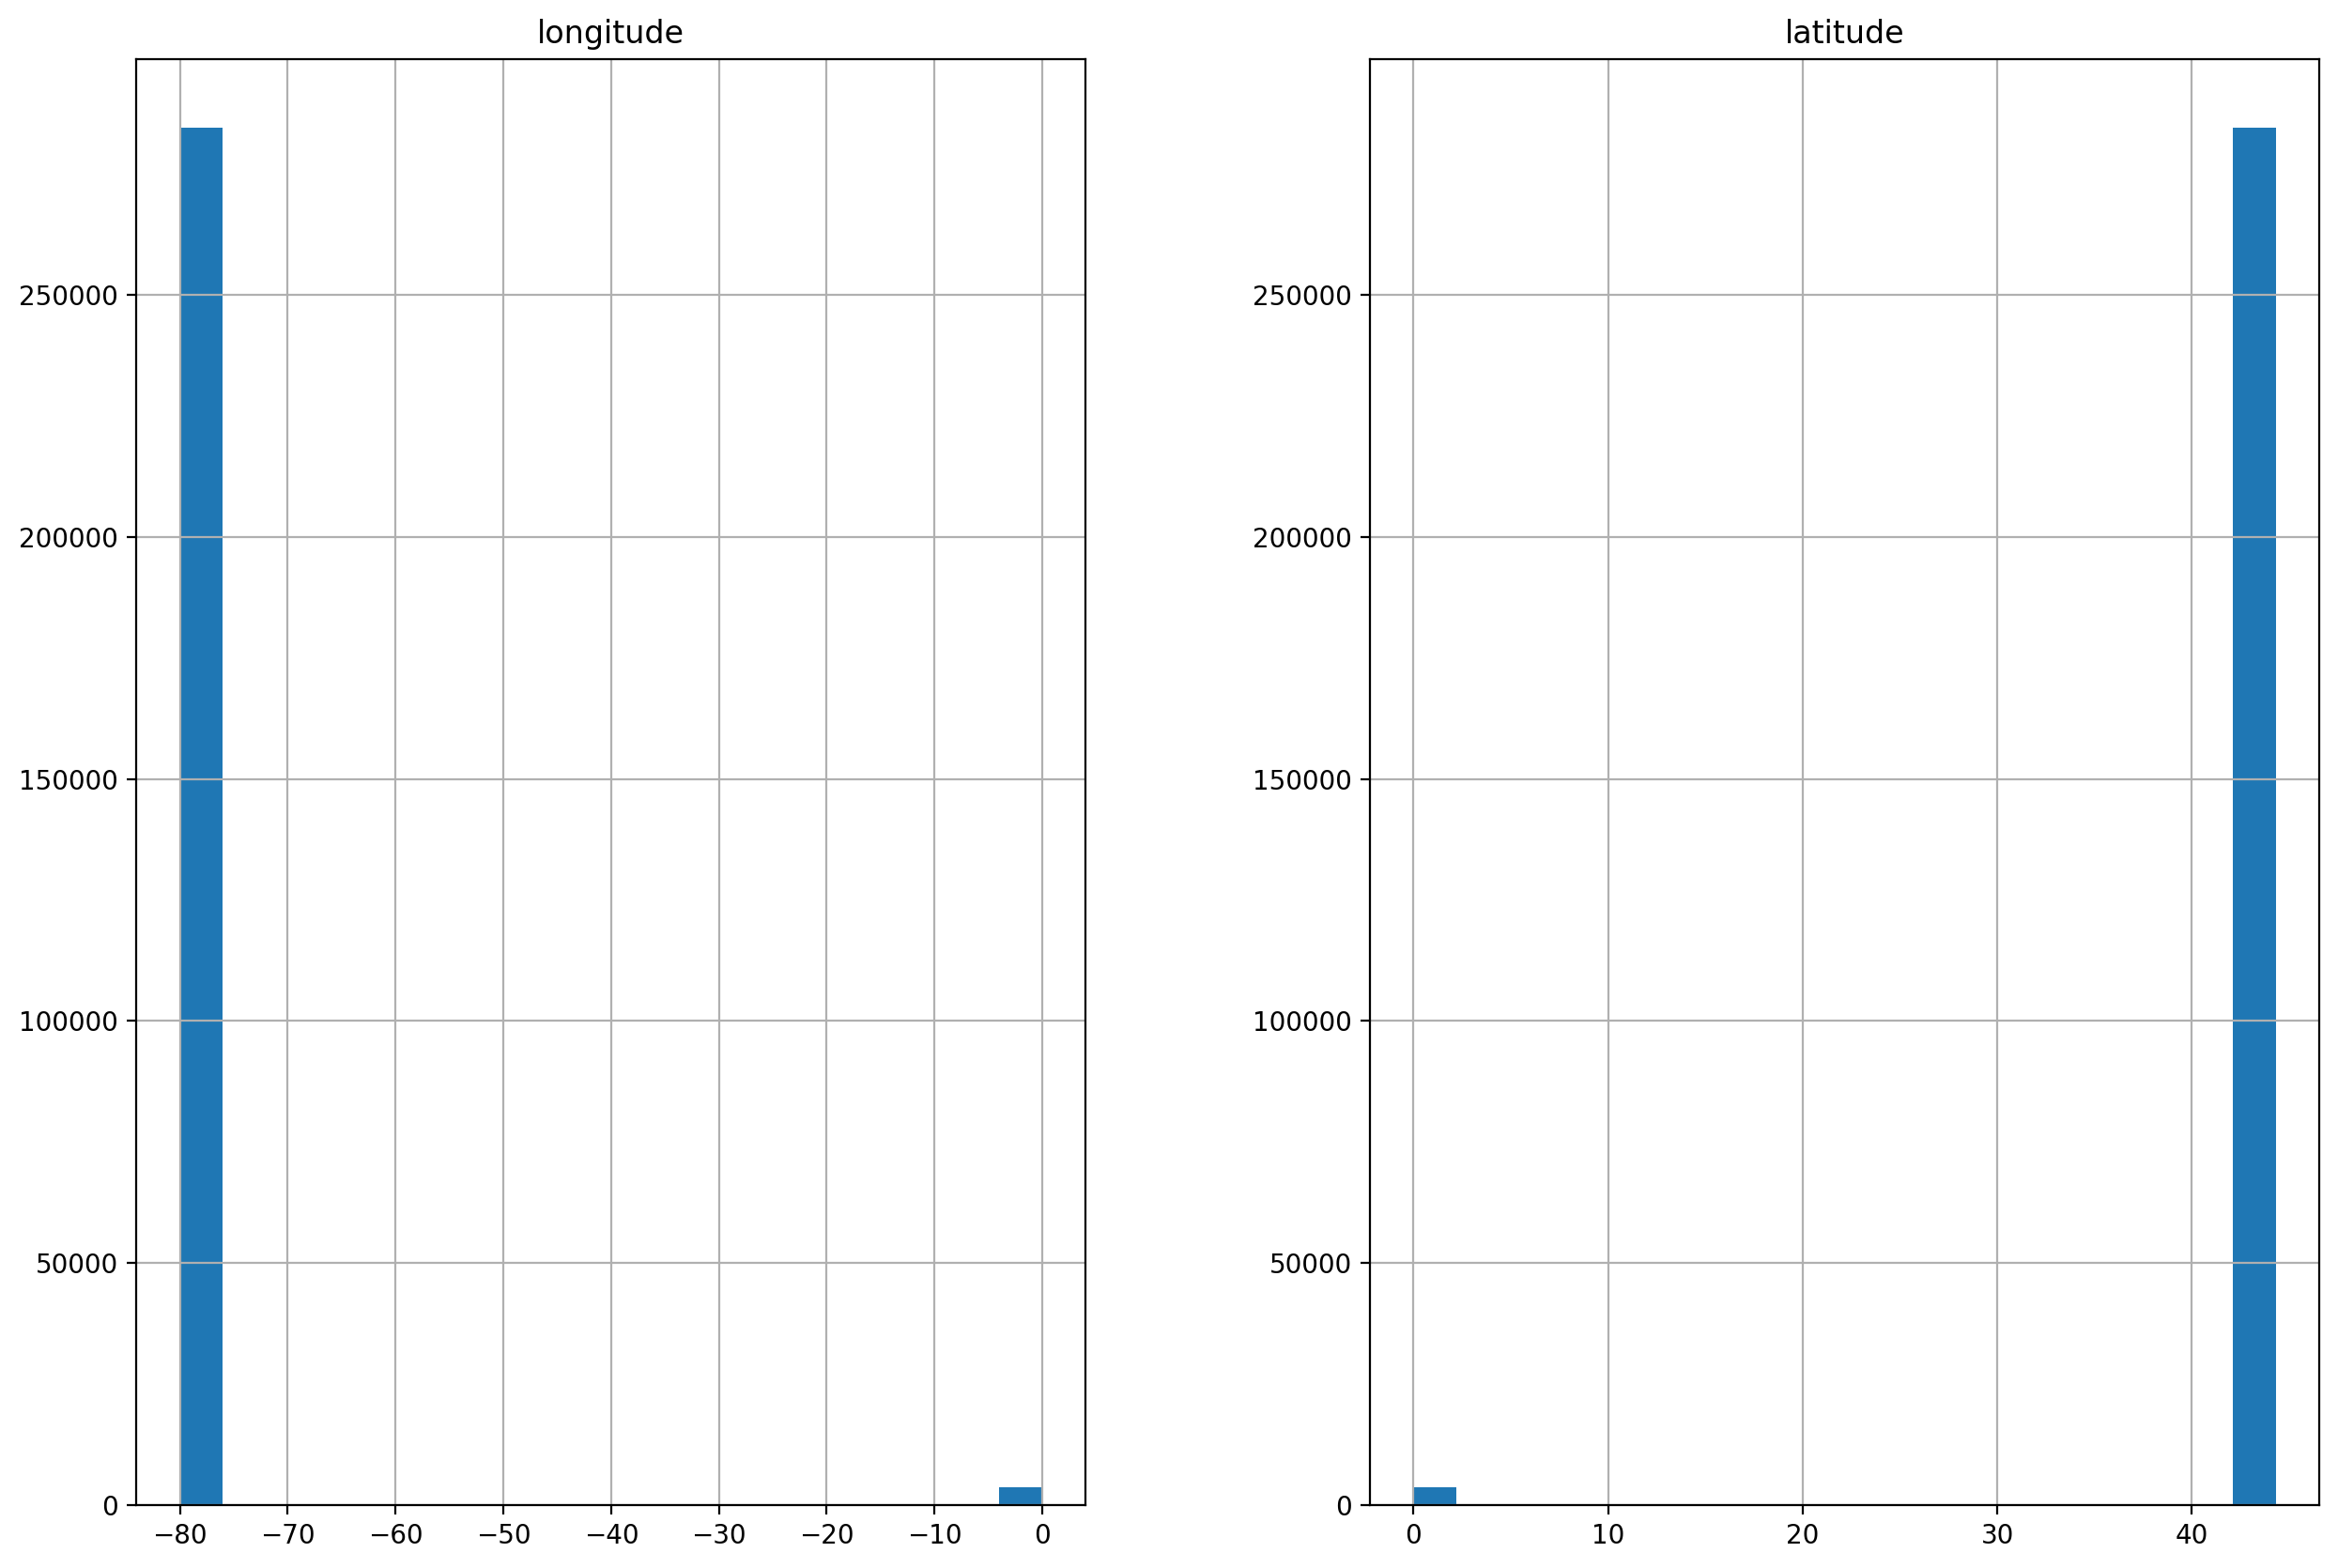

In [232]:
# missing longitude and latitude values are stored as 0
mci_df[['longitude','latitude']].hist(bins=20)

In [233]:
mci_df.loc[(mci_df['longitude'] == 0) & (mci_df['latitude'] == 0), ["neighbourhood", "hood_id"]].value_counts()

neighbourhood                        hood_id
NSA                                  NSA        3396
Wexford/Maryvale                     119          57
Yorkdale-Glen Park                   31           38
West Hill                            136          25
Bay Street Corridor                  76           17
York University Heights              27           15
Bendale                              127          15
Glenfield-Jane Heights               25           13
Kennedy Park                         124           7
Mimico (includes Humber Bay Shores)  17            6
Tam O'Shanter-Sullivan               118           5
Highland Creek                       134           5
Victoria Village                     43            5
Downsview-Roding-CFB                 26            4
Pelmo Park-Humberlea                 23            4
Newtonbrook East                     50            4
Clairlea-Birchmount                  120           4
Bathurst Manor                       34            4
H

### Estimate with given neighbourhood

In [234]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
mci_df = mci_df[~((mci_df['longitude'] == 0) & (mci_df['latitude'] == 0) & (mci_df['neighbourhood'] == "NSA"))].reset_index(drop=True)

In [235]:
missing_location = mci_df.loc[(mci_df['longitude'] == 0) & (mci_df['latitude'] == 0)].index
mci_df.loc[missing_location]

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,MCI,hood_id,neighbourhood,longitude,latitude,occurrence_quarter
2720,GO-20181222720,2018-07-05 12:00:00,2018,July,5,186,Thursday,Assault,1,West Humber-Clairville,0.0,0.0,3
9125,GO-20192152732,2019-11-07 13:00:00,2019,November,7,311,Thursday,Assault,2,Mount Olive-Silverstone-Jamestown,0.0,0.0,4
9500,GO-20171616525,2017-09-06 12:00:00,2017,September,6,249,Wednesday,Assault,2,Mount Olive-Silverstone-Jamestown,0.0,0.0,3
10361,GO-20141665589,2014-03-08 13:00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,0.0,0.0,1
10362,GO-20141665589,2014-03-08 13:00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265918,GO-2019279847,2019-02-13 13:00:00,2019,February,13,44,Wednesday,Assault,136,West Hill,0.0,0.0,1
266580,GO-20201116842,2020-06-17 12:00:00,2020,June,17,169,Wednesday,Assault,136,West Hill,0.0,0.0,2
271074,GO-20191794829,2019-09-18 12:00:00,2019,September,18,261,Wednesday,Assault,137,Woburn,0.0,0.0,3
273746,GO-20181409483,2018-07-31 12:00:00,2018,July,31,212,Tuesday,Assault,138,Eglinton East,0.0,0.0,3


In [236]:
missing_count = mci_df.loc[missing_location]['hood_id'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'hood_id', 'hood_id':'count'})
missing_count

,hood_id,count
0,119,57
1,31,38
2,136,25
3,76,17
4,27,15
5,127,15
6,25,13
7,124,7
8,17,6
9,134,5


### Generate random locations given a neighbourhood

In [237]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.unique().bounds.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

12 points generated but only include the 10 points within the neighbourhood


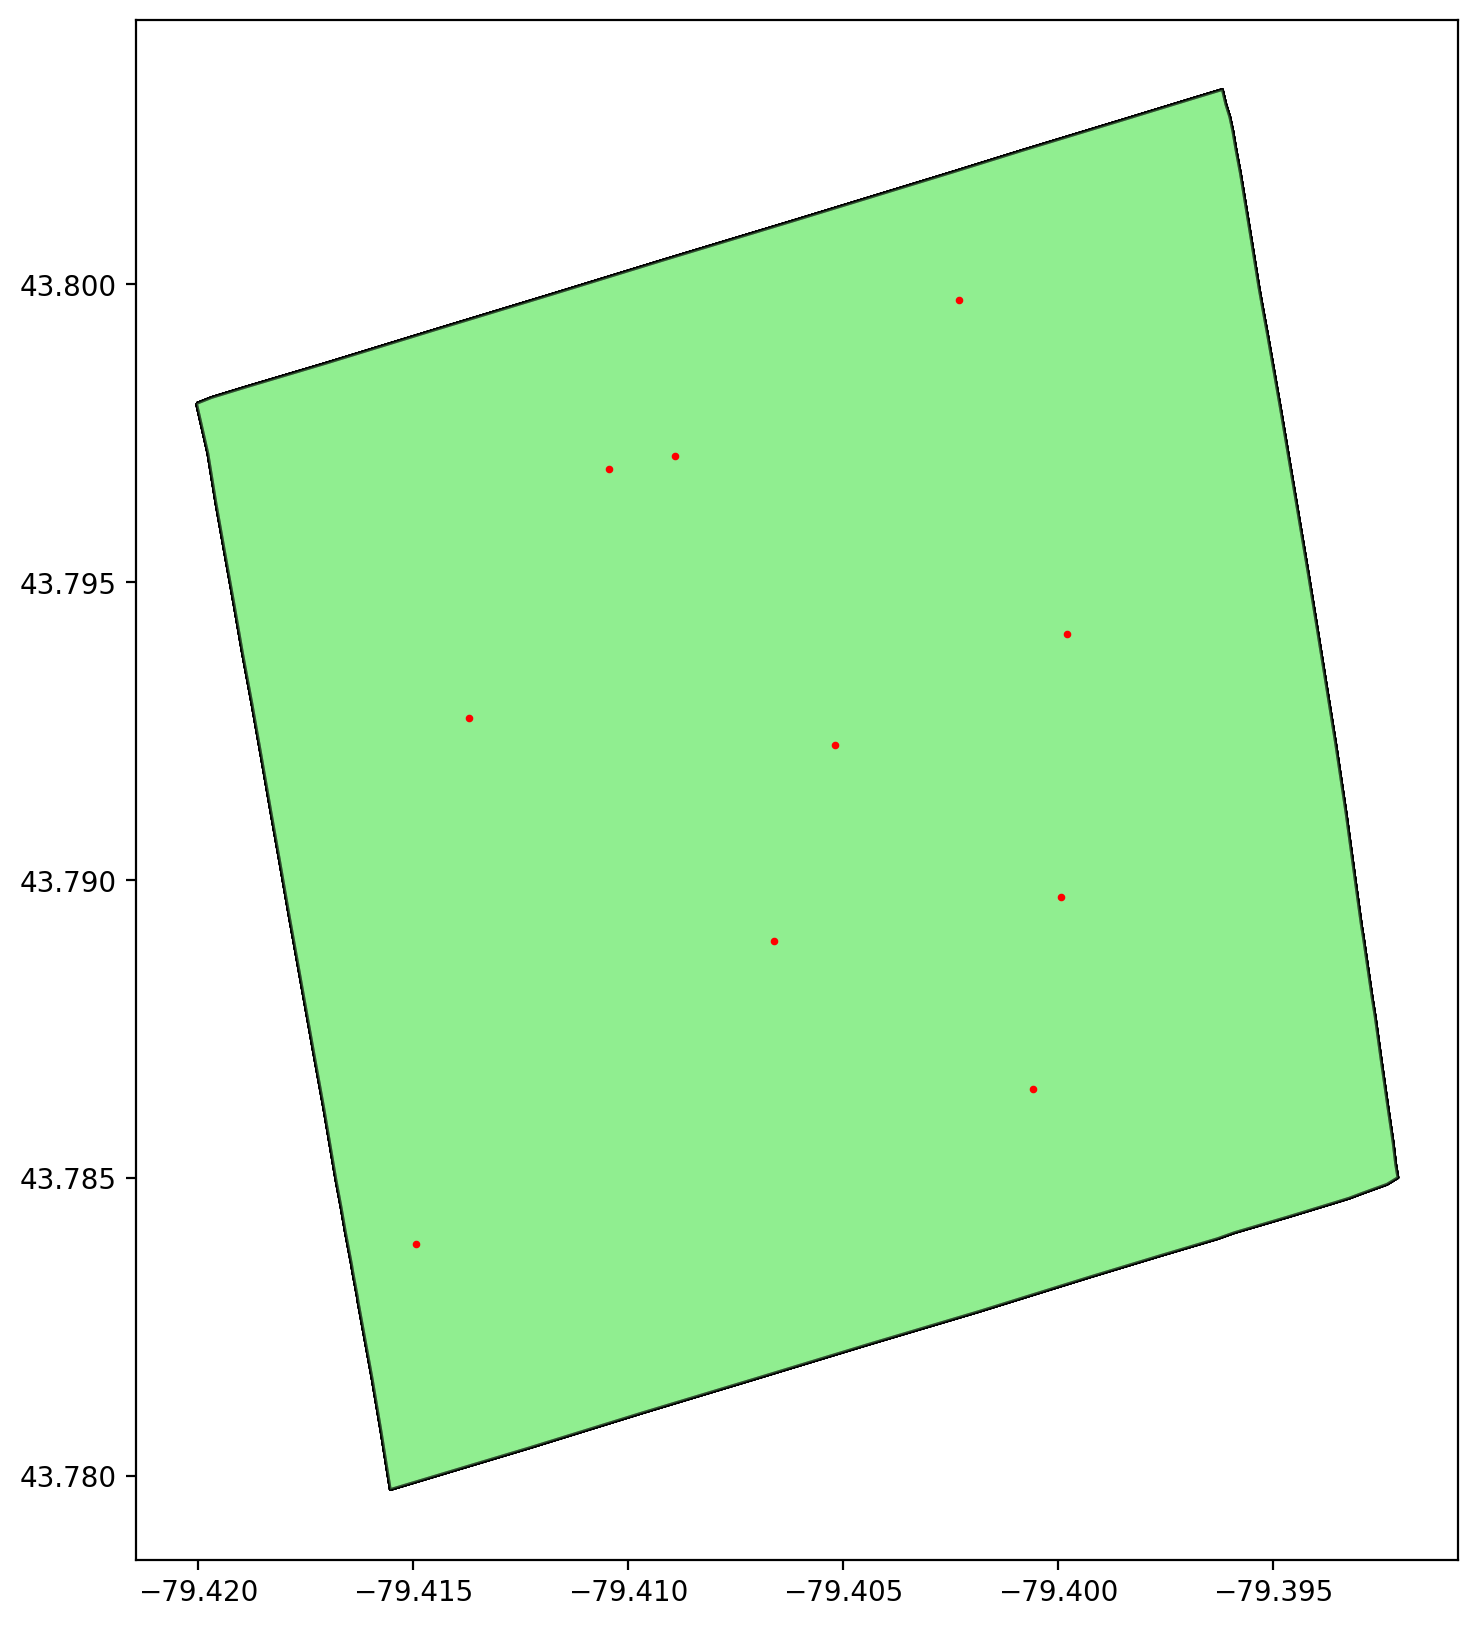

In [238]:
# select one hood_id to test
hood = 50
np.random.seed(123)
random_x, random_y = generate_random(10, hood)

# random points should lie within the neighbourhood
# no red dots should be outside the neighbourhood
ax = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood)].plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
plt.scatter(random_x, random_y, 
            color = 'red', s = 3)

In [239]:
np.random.seed(123)
missing_count[['longitude', 'latitude']] = missing_count.apply(lambda x: generate_random(x['count'],x['hood_id']), axis=1)

78 points generated but only include the 57 points within the neighbourhood
68 points generated but only include the 38 points within the neighbourhood
36 points generated but only include the 25 points within the neighbourhood
33 points generated but only include the 17 points within the neighbourhood
21 points generated but only include the 15 points within the neighbourhood
25 points generated but only include the 15 points within the neighbourhood
17 points generated but only include the 13 points within the neighbourhood
11 points generated but only include the 7 points within the neighbourhood
12 points generated but only include the 6 points within the neighbourhood
11 points generated but only include the 5 points within the neighbourhood
6 points generated but only include the 5 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
20 points generated but only include the 4 points within the neighbourhood
11 points generated 

In [240]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['longitude'].apply(lambda x: len(x))
missing_count

,hood_id,count,longitude,latitude,len
0,119,57,"[-79.2905474645034, -79.31024017310659, -79.28...","[43.73845162529402, 43.75118356521948, 43.7450...",57
1,31,38,"[-79.4499056676438, -79.44883602114473, -79.45...","[43.72667387681818, 43.71306448845523, 43.7229...",38
2,136,25,"[-79.18296212725186, -79.19663494516615, -79.1...","[43.77929081550005, 43.77017760574194, 43.7777...",25
3,76,17,"[-79.38932911965928, -79.38449277038399, -79.3...","[43.66365378334848, 43.65329698972922, 43.6624...",17
4,27,15,"[-79.50615108937204, -79.49818915895317, -79.4...","[43.754671908621695, 43.75079559393119, 43.762...",15
5,127,15,"[-79.26173575446603, -79.25071559017856, -79.2...","[43.75266128515352, 43.743225602686515, 43.750...",15
6,25,13,"[-79.52250802047399, -79.52515598534787, -79.5...","[43.741598652510895, 43.74056161975028, 43.747...",13
7,124,7,"[-79.2698888813491, -79.26348211881192, -79.25...","[43.7261945181042, 43.719760984625516, 43.7260...",7
8,17,6,"[-79.48539949794953, -79.48636352360387, -79.5...","[43.62072175983447, 43.62428155568899, 43.6152...",6
9,134,5,"[-79.17564550360225, -79.17614106413124, -79.1...","[43.79215548764676, 43.78358798245847, 43.7810...",5


In [241]:
# impute the missing long and lat values
for i in missing_count["hood_id"].unique():    
    index = (mci_df['hood_id'] == str(i)) & ((mci_df['longitude'] == 0) | (mci_df['latitude'] == 0))
    # mci_df.loc[index, ['longitude', 'latitude']] = 
    mci_df.loc[index, ['longitude', 'latitude']] = pd.DataFrame([np.where(mci_df.loc[index, 'longitude'] == 0, 
                                                                  missing_count[missing_count['hood_id'] == str(i)]['longitude'].values[0],
                                                                  mci_df.loc[index, 'longitude']),
                                                         np.where(mci_df.loc[index, 'latitude'] == 0, 
                                                                  missing_count[missing_count['hood_id'] == str(i)]['latitude'].values[0],
                                                                  mci_df.loc[index, 'latitude'])]).T.values

In [242]:
# check missing long and lat values are now imputed
mci_df.loc[missing_location]

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,MCI,hood_id,neighbourhood,longitude,latitude,occurrence_quarter
2720,GO-20181222720,2018-07-05 12:00:00,2018,July,5,186,Thursday,Assault,1,West Humber-Clairville,-79.567220,43.701489,3
9125,GO-20192152732,2019-11-07 13:00:00,2019,November,7,311,Thursday,Assault,2,Mount Olive-Silverstone-Jamestown,-79.579915,43.761974,4
9500,GO-20171616525,2017-09-06 12:00:00,2017,September,6,249,Wednesday,Assault,2,Mount Olive-Silverstone-Jamestown,-79.580581,43.731631,3
10361,GO-20141665589,2014-03-08 13:00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,-79.561101,43.738548,1
10362,GO-20141665589,2014-03-08 13:00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,-79.546795,43.740109,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265918,GO-2019279847,2019-02-13 13:00:00,2019,February,13,44,Wednesday,Assault,136,West Hill,-79.170669,43.759099,1
266580,GO-20201116842,2020-06-17 12:00:00,2020,June,17,169,Wednesday,Assault,136,West Hill,-79.164050,43.759760,2
271074,GO-20191794829,2019-09-18 12:00:00,2019,September,18,261,Wednesday,Assault,137,Woburn,-79.249664,43.769874,3
273746,GO-20181409483,2018-07-31 12:00:00,2018,July,31,212,Tuesday,Assault,138,Eglinton East,-79.247611,43.738554,3


### Add geometry for points

In [243]:
mci_df['geometry'] = mci_df.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [244]:
# Documentation: The location of crime occurrences have been deliberately offset 
# to the nearest road intersection node 
# to protect the privacy of parties involved in the occurrence
mci_point = gpd.GeoDataFrame(mci_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

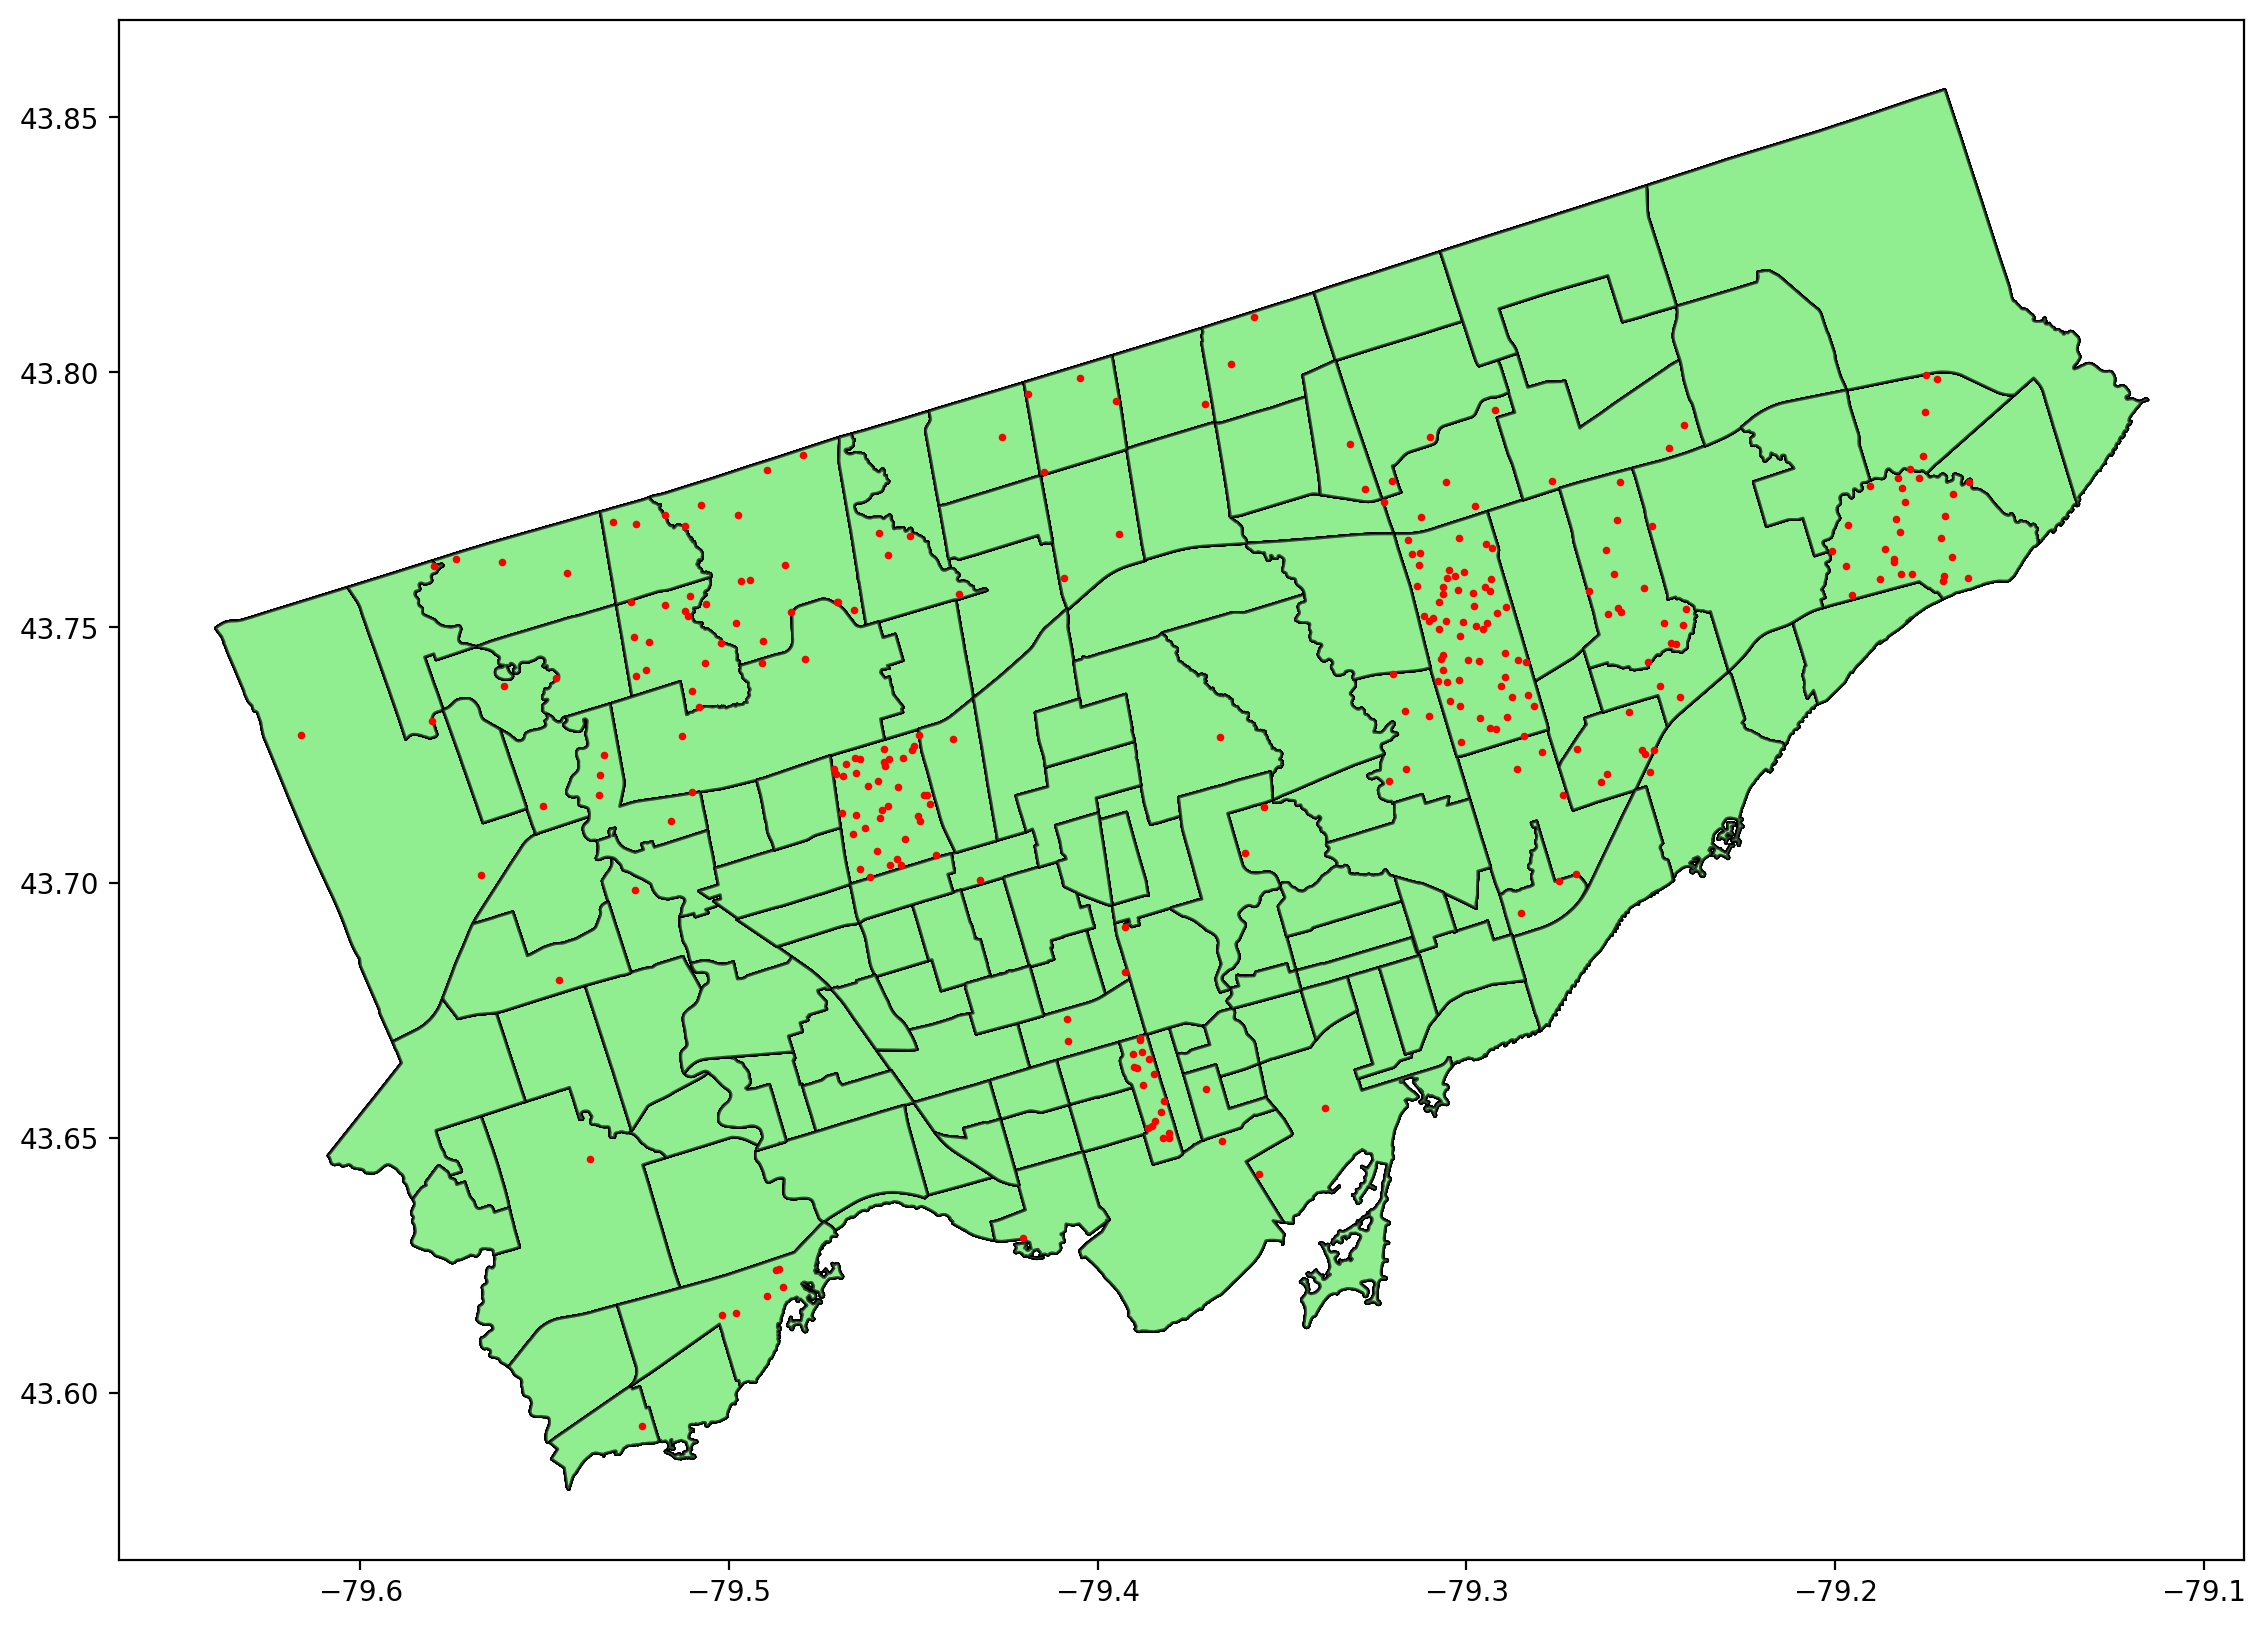

In [245]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

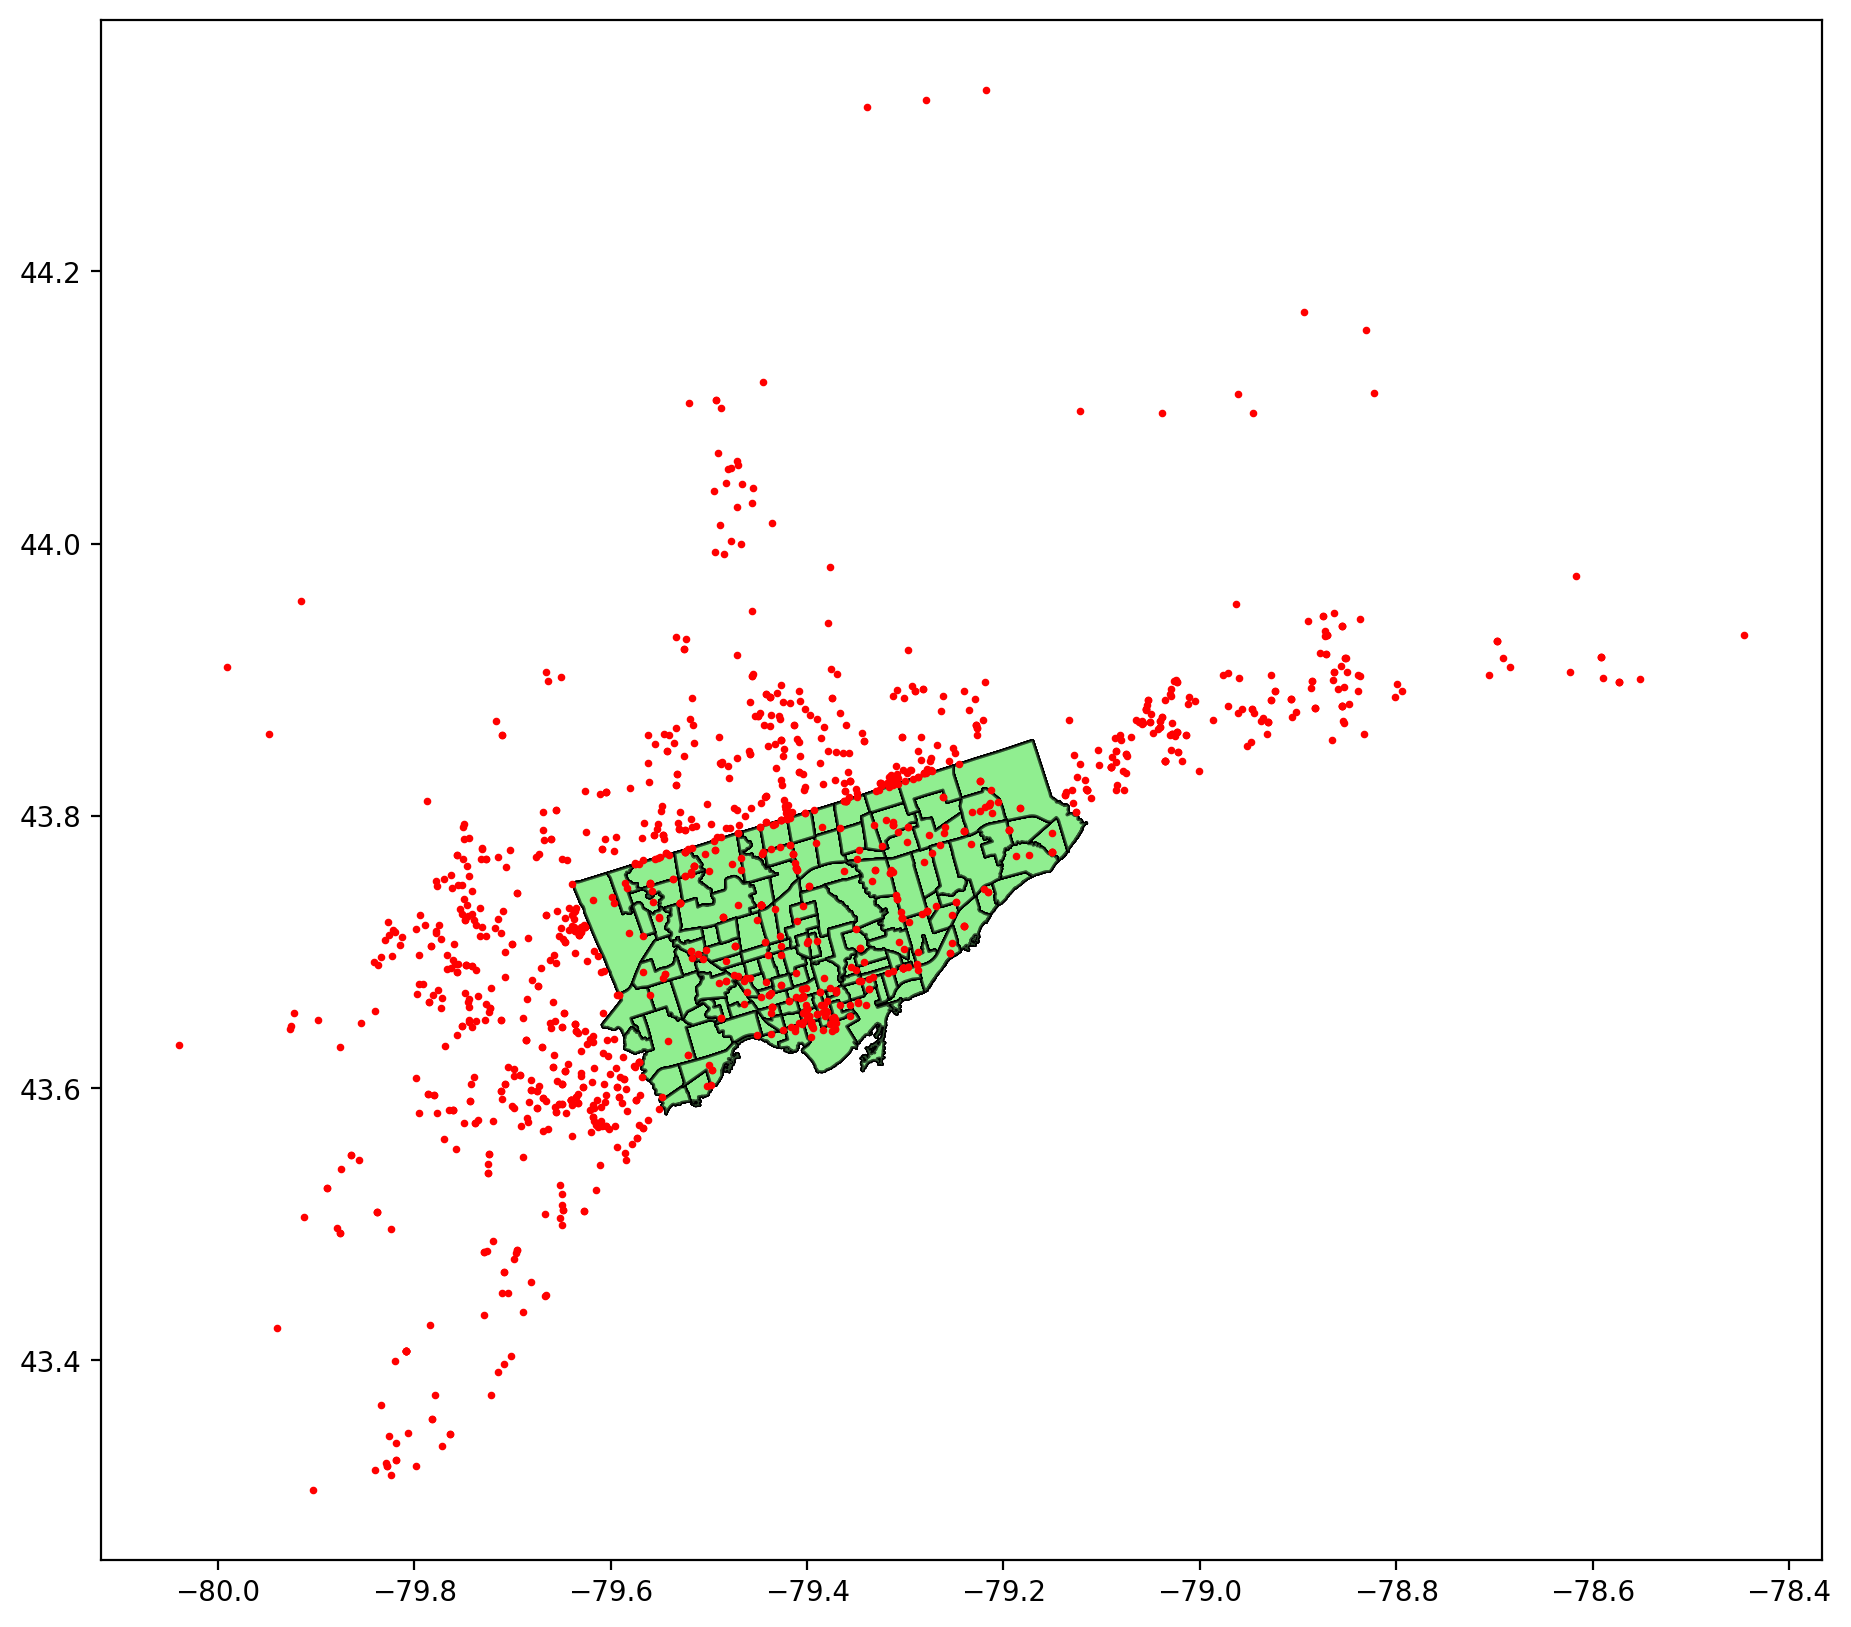

In [246]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [247]:
# get the points contained within the neighbourhoods
NSA_within_neighbourhood = gpd.sjoin(mci_point[mci_point['neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
mci_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'neighbourhood_right']].values

c:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

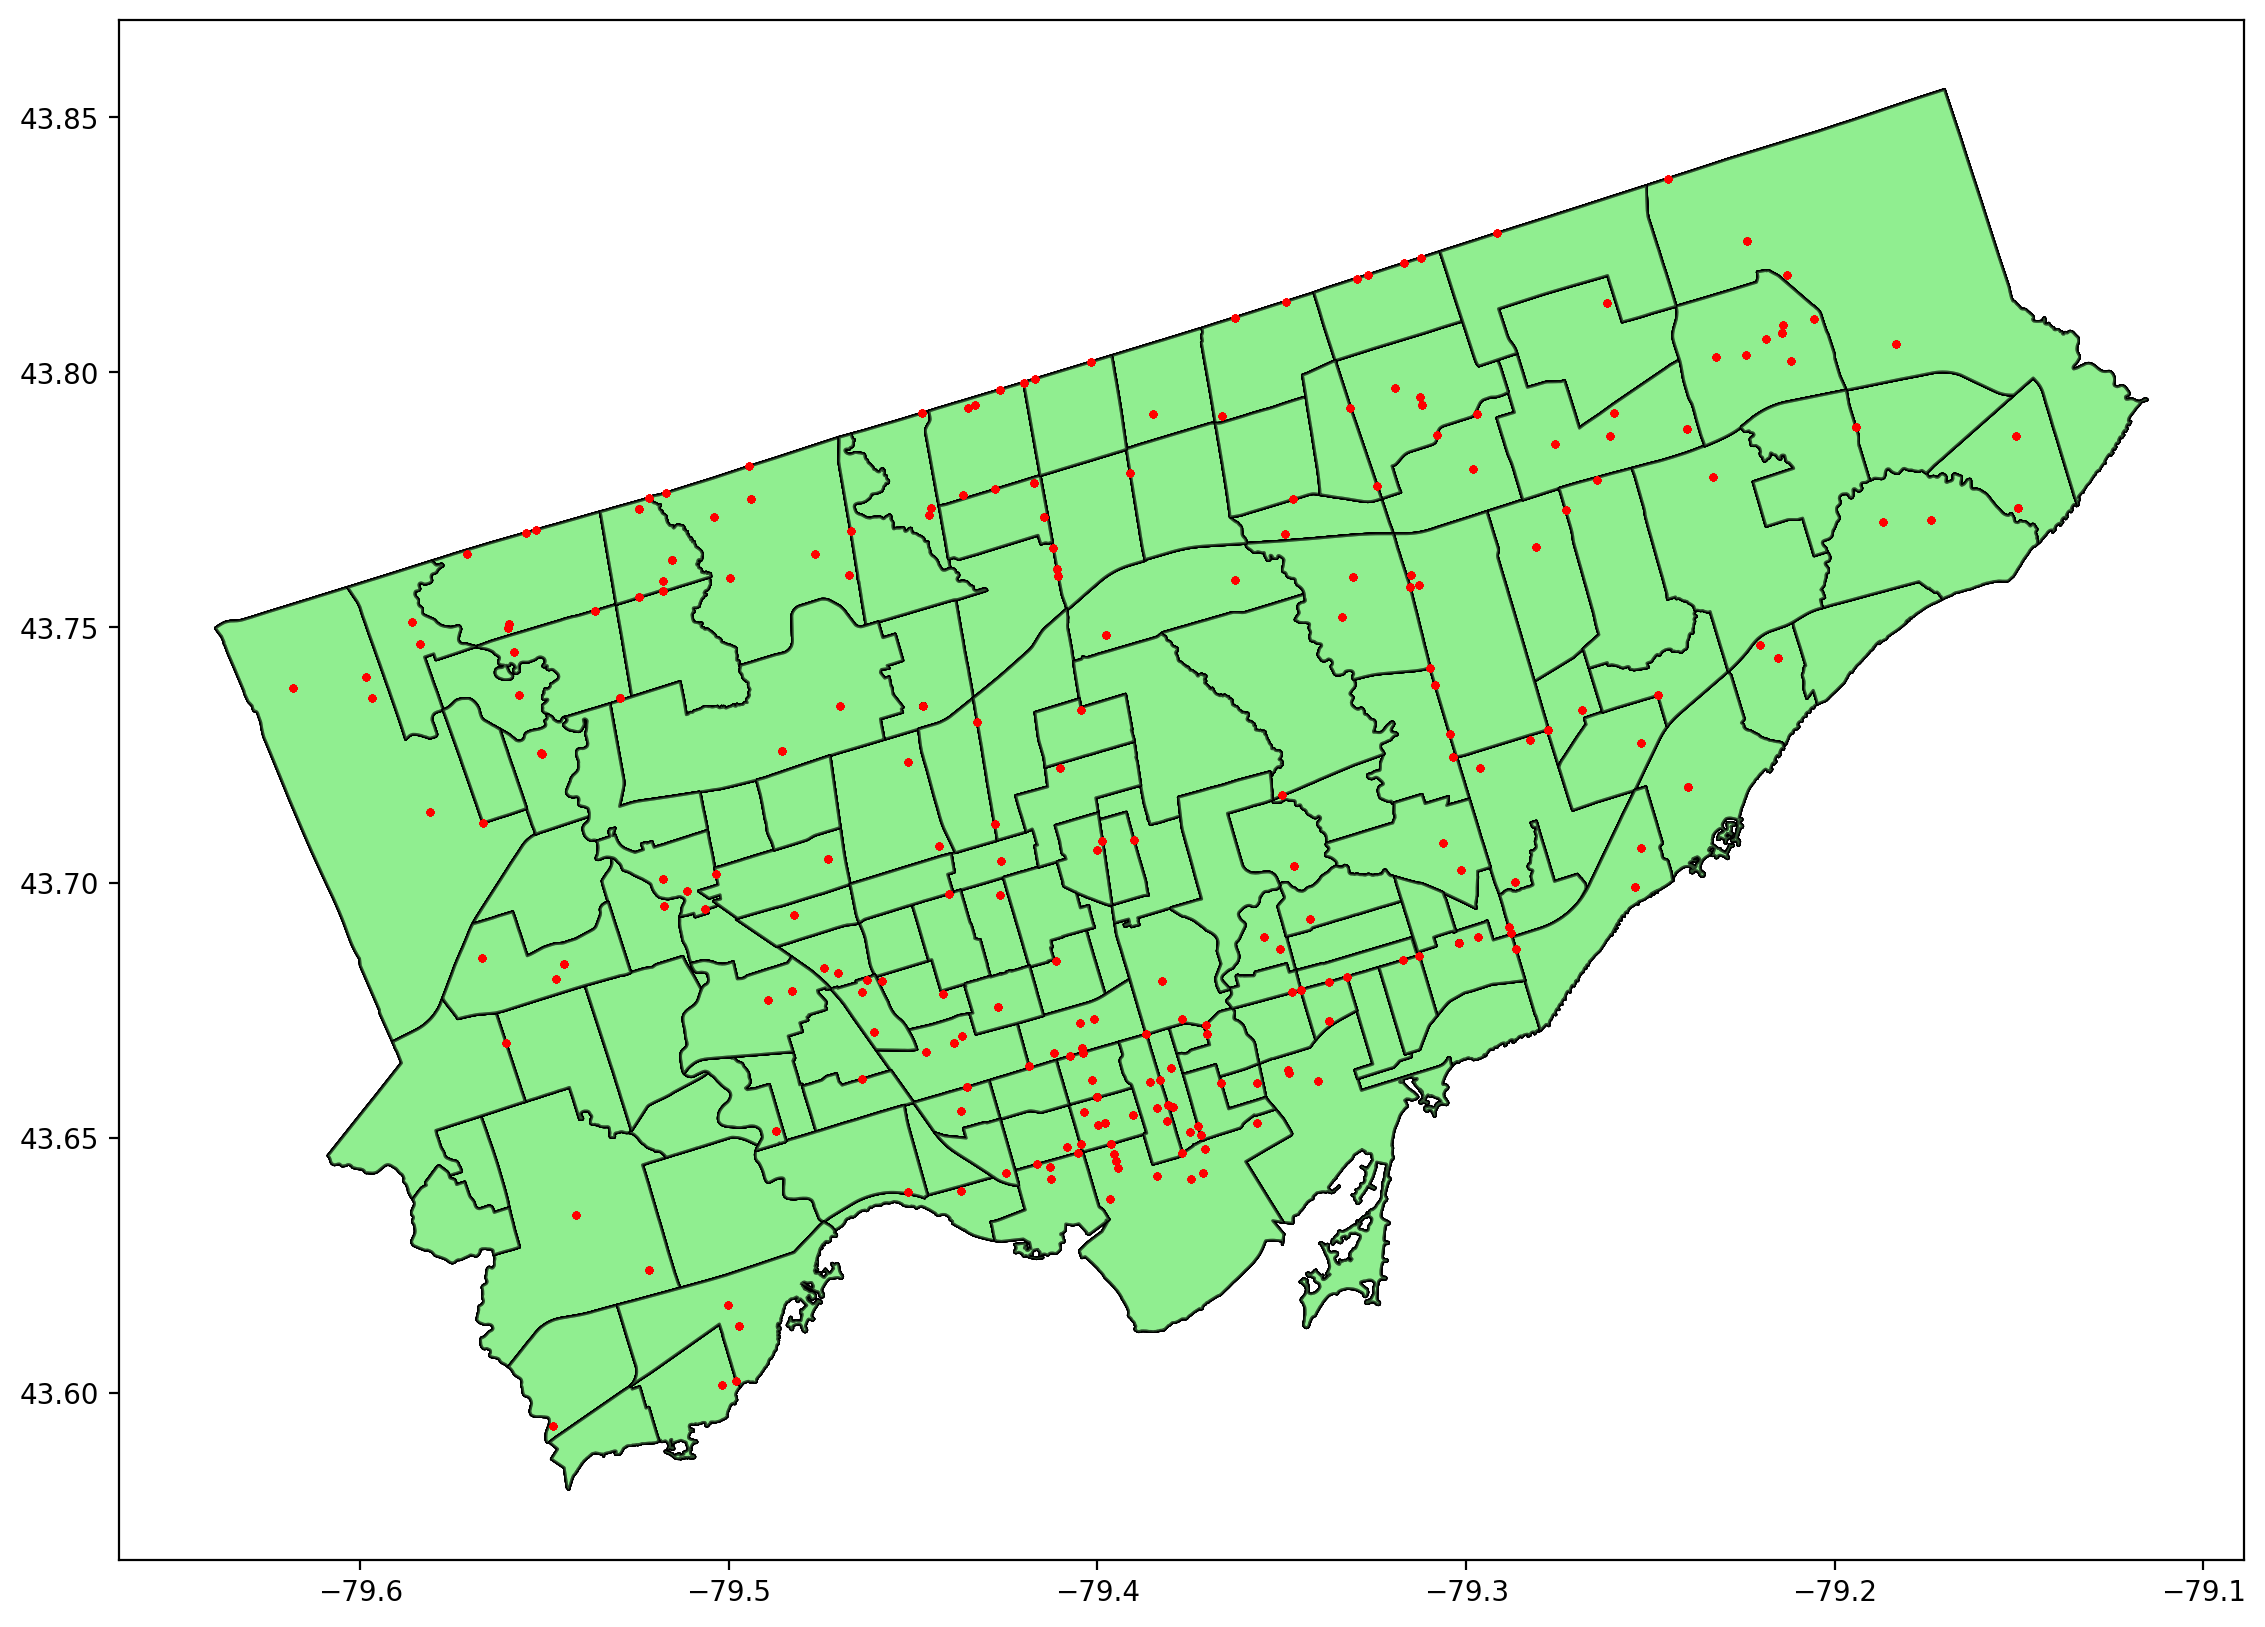

In [248]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

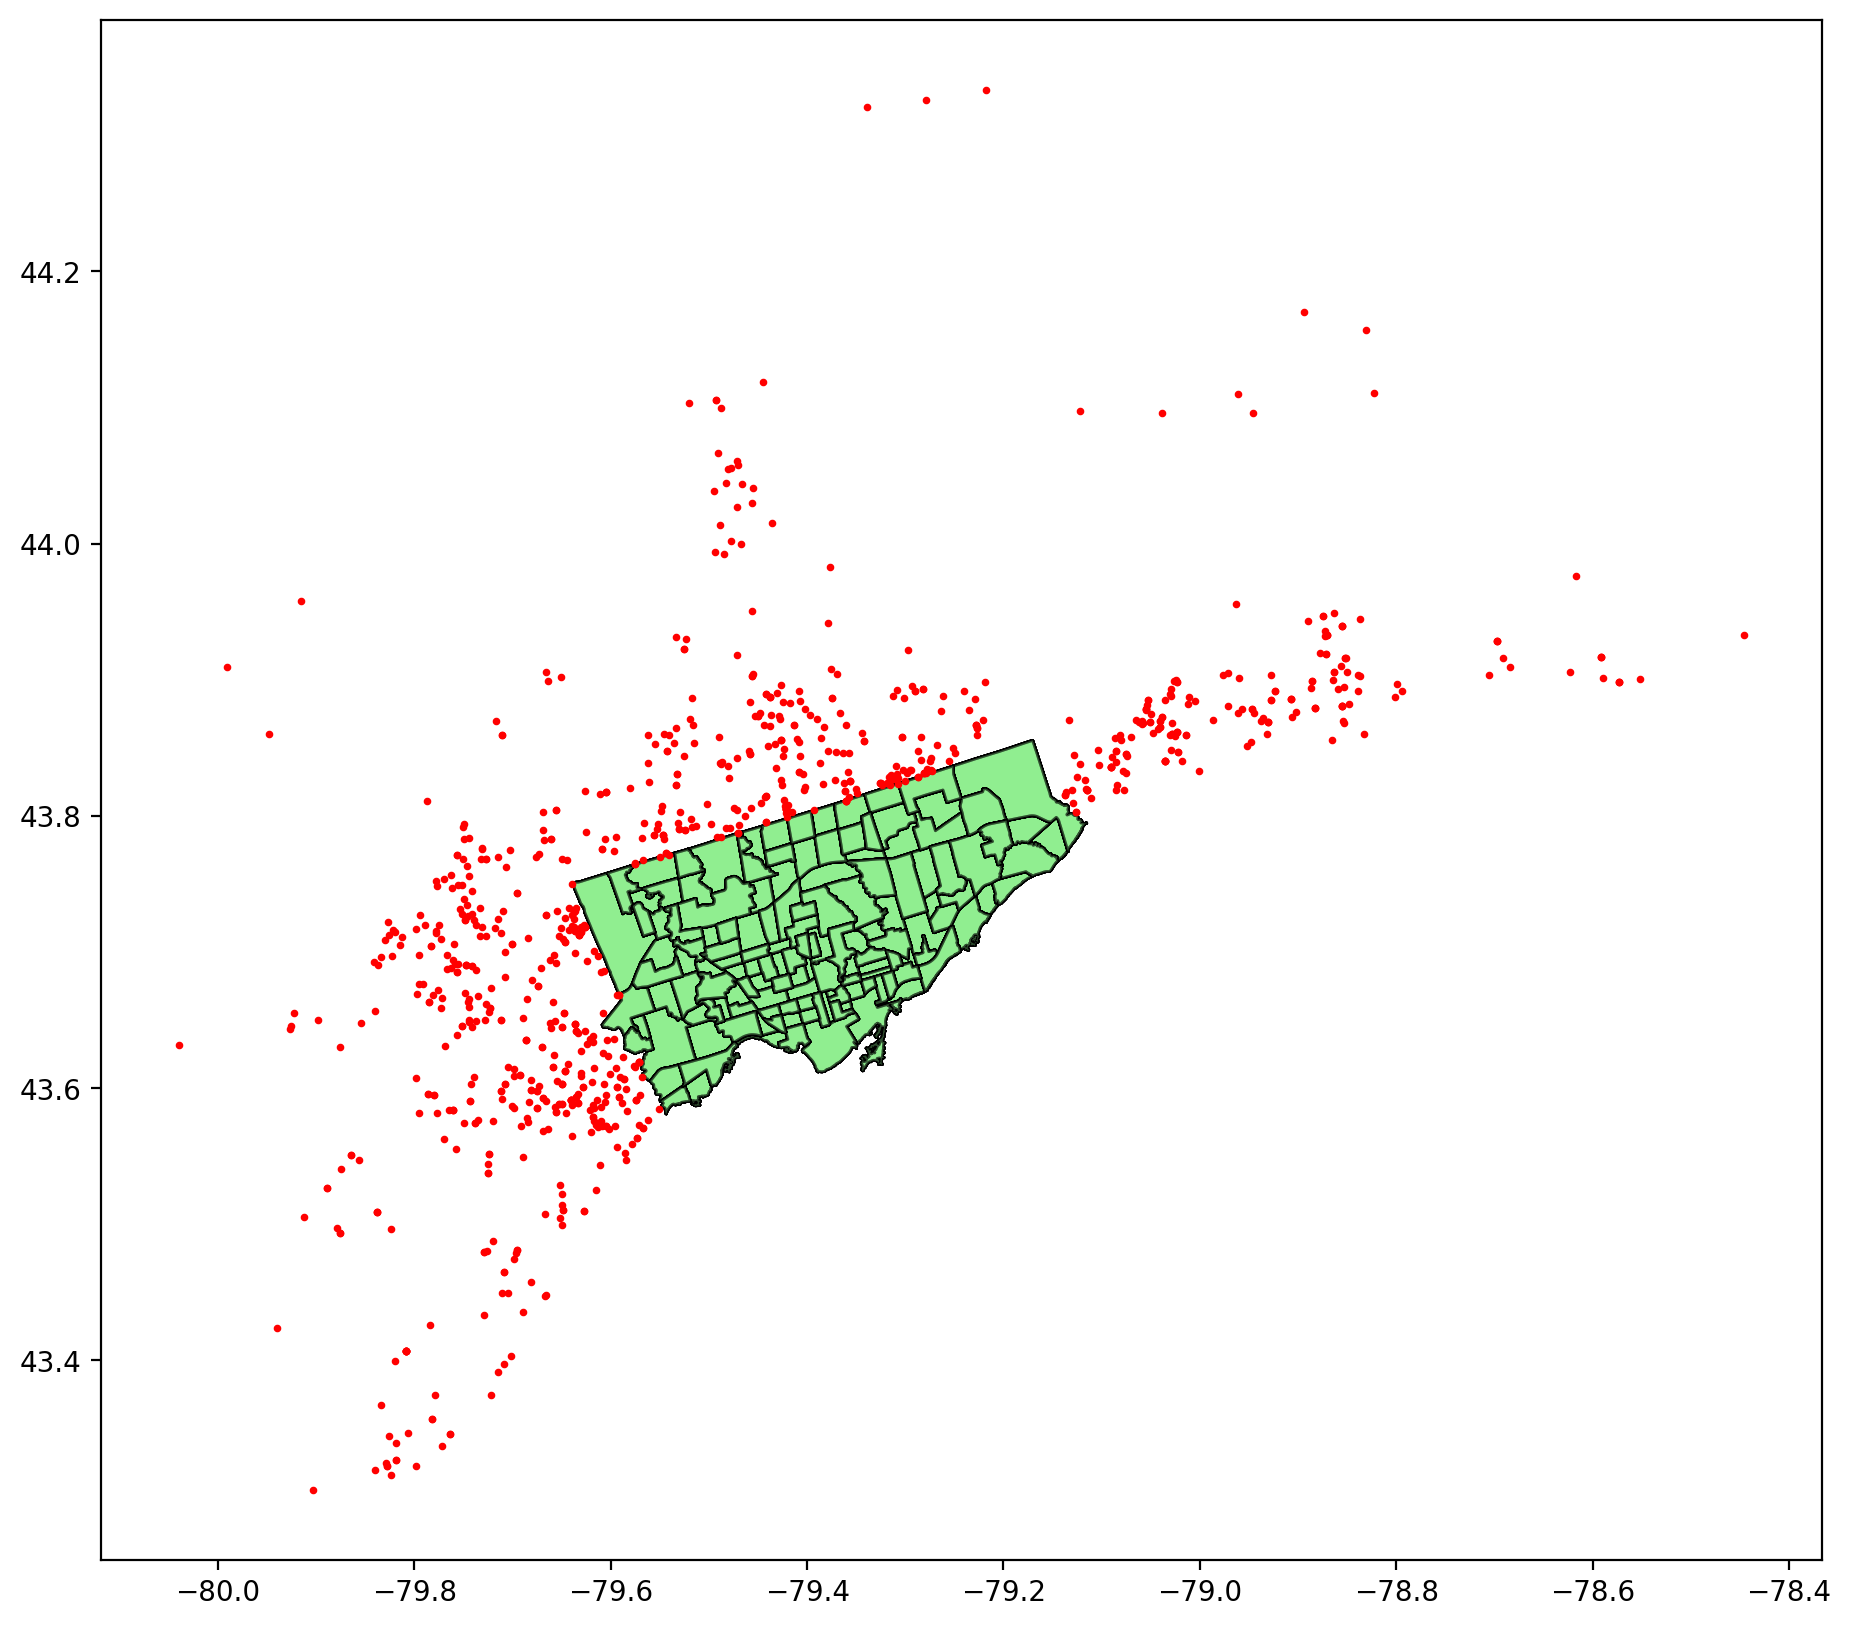

In [249]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
# no red dots should be inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

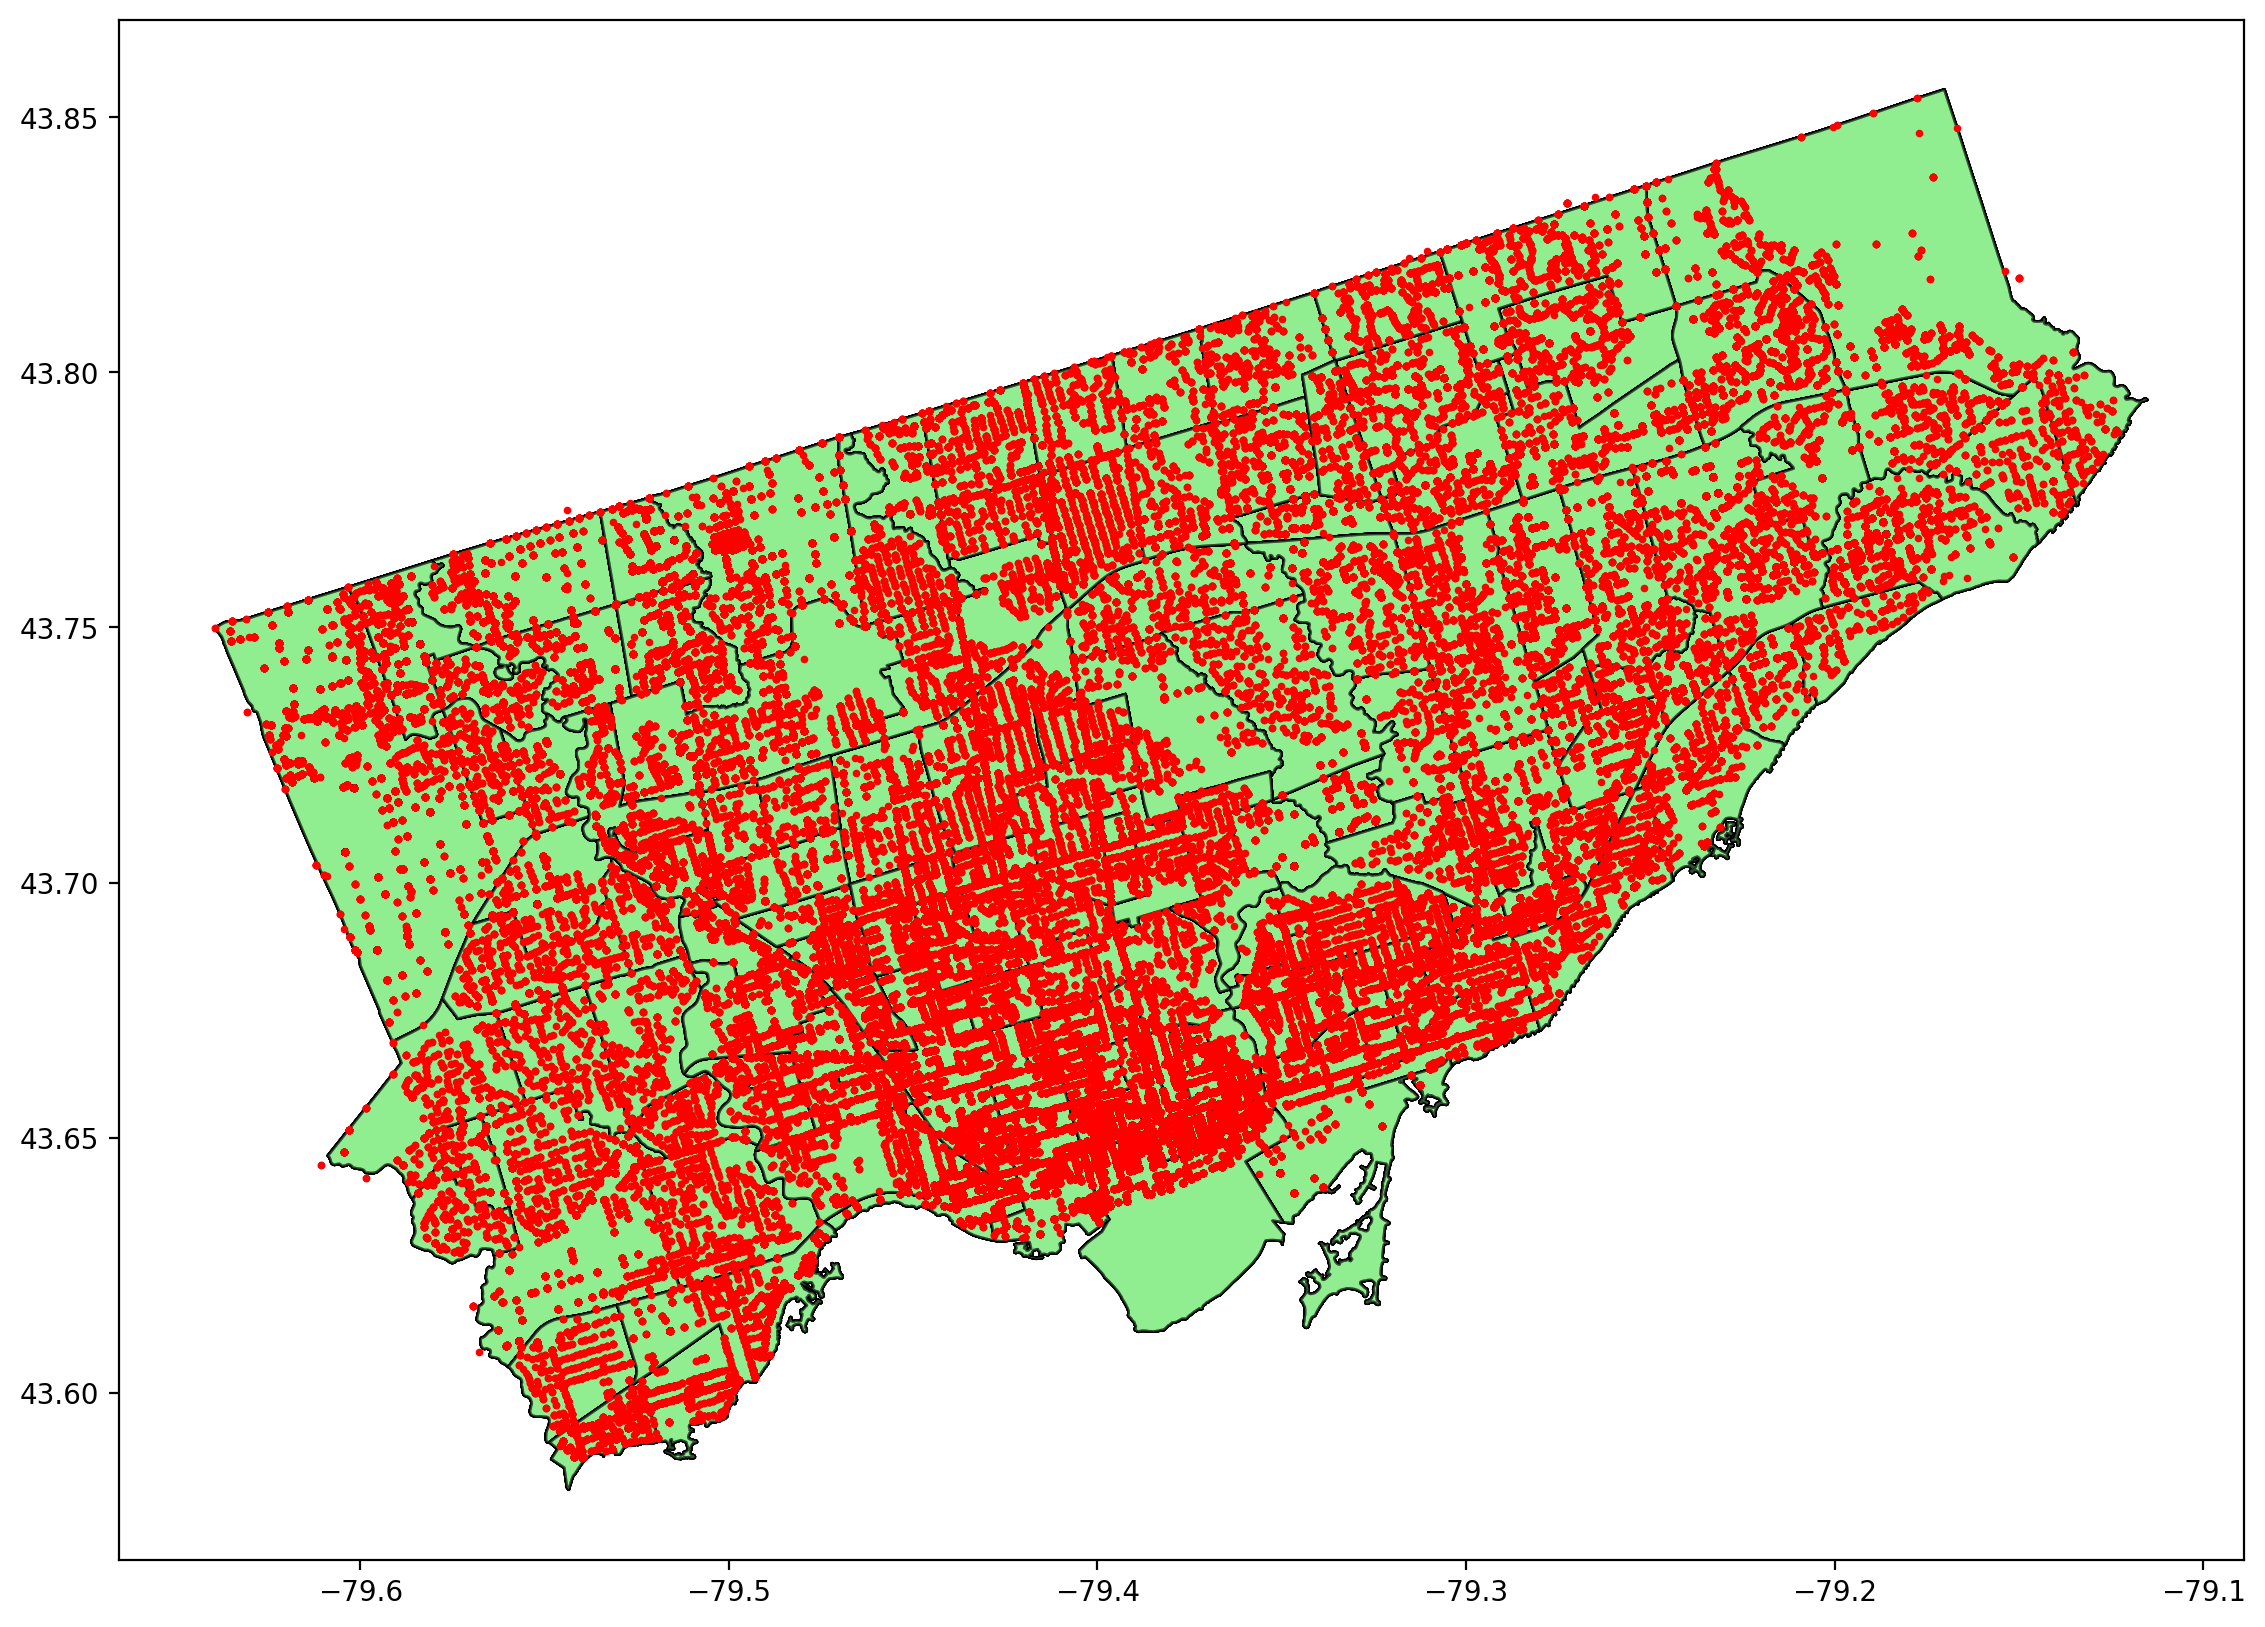

In [250]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Output

In [251]:
mci_point

,occurrence_unique_id,occurrence_date,occurrence_year,occurrence_month,occurrence_day,occurrence_dayofyear,occurrence_dayofweek,MCI,hood_id,neighbourhood,longitude,latitude,occurrence_quarter,geometry
0,GO-20141625305,2014-03-02 13:00:00,2014,March,2,61,Sunday,Assault,1,West Humber-Clairville,-79.590332,43.734013,1,POINT (-79.59033 43.73401)
1,GO-20141272968,2013-12-24 13:00:00,2013,December,24,358,Tuesday,Robbery,1,West Humber-Clairville,-79.600701,43.731834,4,POINT (-79.60070 43.73183)
2,GO-20141284361,2013-01-05 13:00:00,2013,January,5,5,Saturday,Assault,1,West Humber-Clairville,-79.600794,43.686423,1,POINT (-79.60079 43.68642)
3,GO-20141292177,2013-12-31 13:00:00,2013,December,31,365,Tuesday,Break and Enter,1,West Humber-Clairville,-79.603876,43.743642,4,POINT (-79.60388 43.74364)
4,GO-20141297201,2014-01-03 13:00:00,2014,January,3,3,Friday,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108,1,POINT (-79.58644 43.69711)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284868,1905589,2006-10-09 12:00:00,2006,October,9,282,Monday,Homicide,43,Victoria Village,-79.304428,43.718907,4,POINT (-79.30443 43.71891)
284869,1696286,2006-10-17 12:00:00,2006,October,17,290,Tuesday,Homicide,119,Wexford/Maryvale,-79.300444,43.727942,4,POINT (-79.30044 43.72794)
284870,1603174,2006-10-21 12:00:00,2006,October,21,294,Saturday,Homicide,135,Morningside,-79.194315,43.789276,4,POINT (-79.19431 43.78928)
284871,1877732,2006-10-27 12:00:00,2006,October,27,300,Friday,Homicide,16,Stonegate-Queensway,-79.496230,43.627735,4,POINT (-79.49623 43.62774)


<AxesSubplot:xlabel='occurrence_year'>

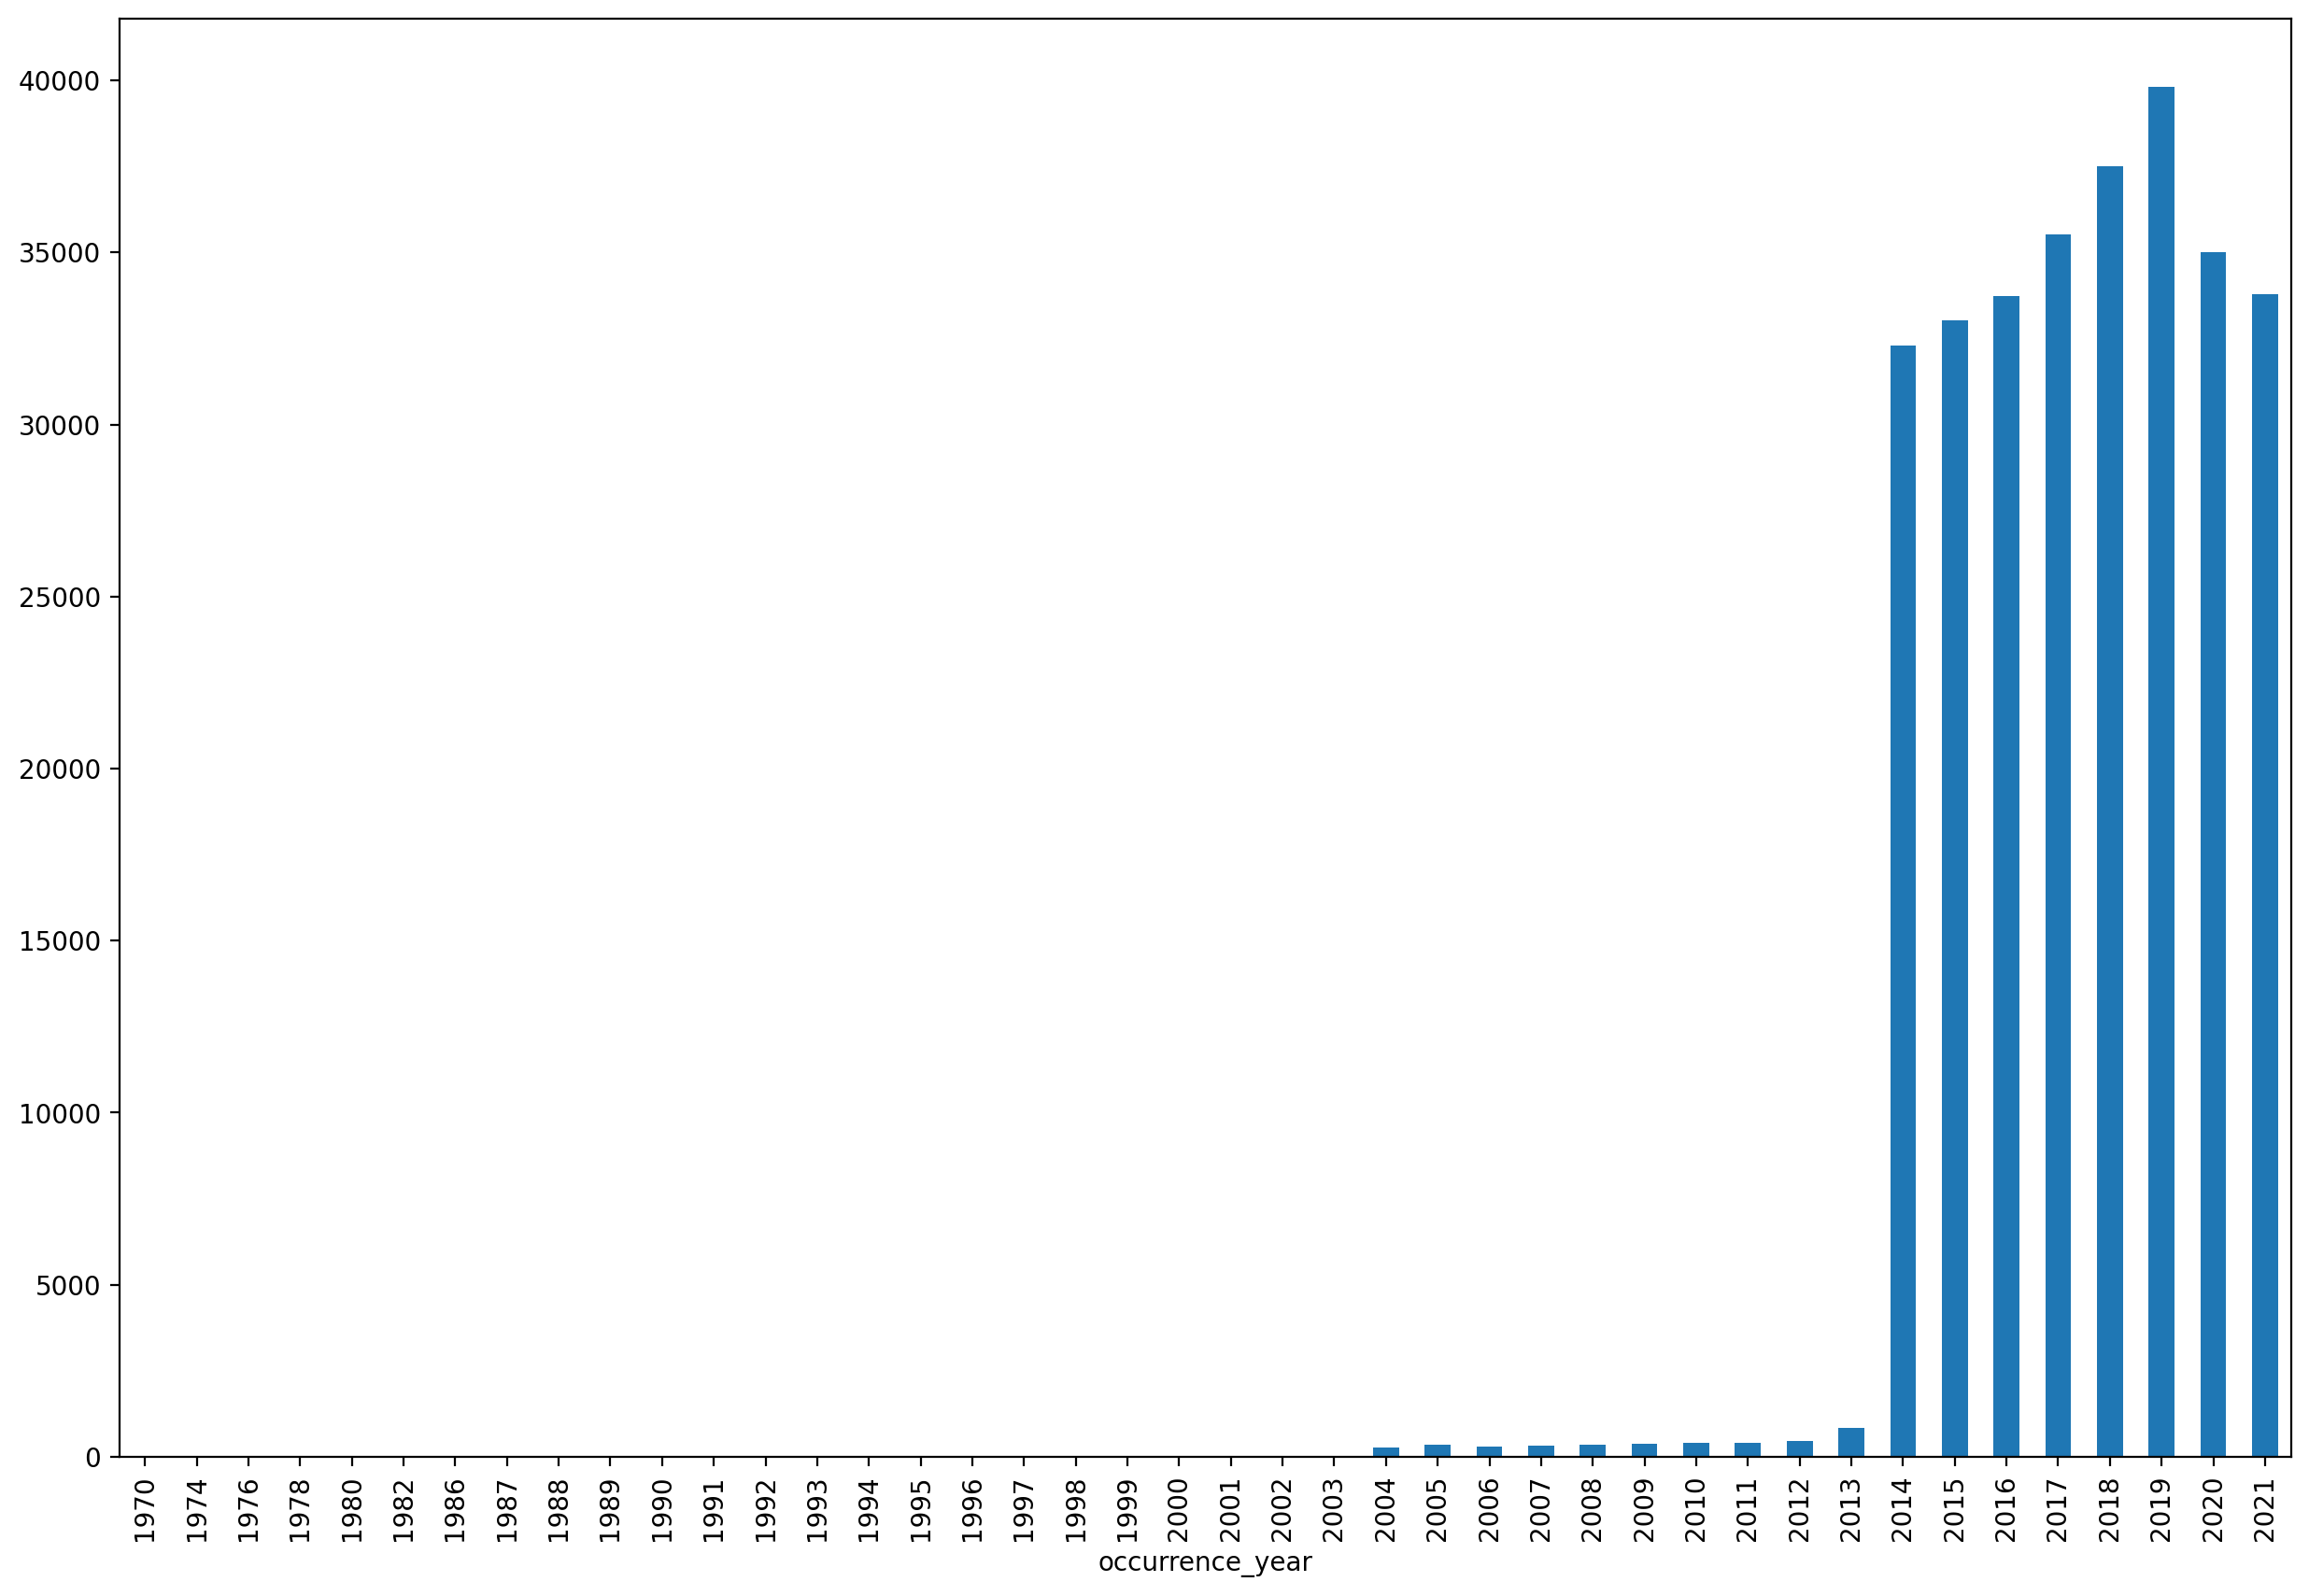

In [252]:
# There is limited data for crimes which happened before 2014
mci_point.groupby("occurrence_year").size().plot(kind="bar")

In [253]:
mci_select = mci_point[mci_point['occurrence_year'] >= 2014]

In [254]:
# output file to processed folder
# csv instead of geojson due to size
mci_select.to_csv('../data/processed/mci_select.csv', index=False)

# Aggregate crimes by quarter after 2014

In [255]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
mci_groupby = mci_select[mci_select.neighbourhood != "NSA"].groupby(["neighbourhood", "hood_id", "occurrence_year", "occurrence_quarter", "MCI"]).size()
# unstack to fill those neighbourhoods with no crime record with 0, e.g. homicide and shootings are rare
mci_groupby = mci_groupby.unstack(fill_value=0).stack().reset_index(name = 'count')
mci_groupby

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,MCI,count
0,Agincourt North,129,2014,1,Assault,19
1,Agincourt North,129,2014,1,Auto Theft,5
2,Agincourt North,129,2014,1,Break and Enter,11
3,Agincourt North,129,2014,1,Homicide,0
4,Agincourt North,129,2014,1,Robbery,12
...,...,...,...,...,...,...
31355,Yorkdale-Glen Park,31,2021,4,Break and Enter,14
31356,Yorkdale-Glen Park,31,2021,4,Homicide,0
31357,Yorkdale-Glen Park,31,2021,4,Robbery,9
31358,Yorkdale-Glen Park,31,2021,4,Shootings,0


In [256]:
mci_groupby.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [257]:
mci_groupby.MCI.unique()

array(['Assault', 'Auto Theft', 'Break and Enter', 'Homicide', 'Robbery',
       'Shootings', 'Theft Over'], dtype=object)

## add MCI aggregate

In [258]:
mci_types = ['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']
mci_crime_all = mci_groupby[mci_groupby['MCI'].isin(mci_types)].groupby(['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter'])[['count']].sum().reset_index()
mci_crime_all["MCI"] = "MCI"

In [259]:
mci_all = pd.concat([mci_groupby, mci_crime_all], axis=0)
mci_all

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,MCI,count
0,Agincourt North,129,2014,1,Assault,19
1,Agincourt North,129,2014,1,Auto Theft,5
2,Agincourt North,129,2014,1,Break and Enter,11
3,Agincourt North,129,2014,1,Homicide,0
4,Agincourt North,129,2014,1,Robbery,12
...,...,...,...,...,...,...
4475,Yorkdale-Glen Park,31,2020,4,MCI,97
4476,Yorkdale-Glen Park,31,2021,1,MCI,55
4477,Yorkdale-Glen Park,31,2021,2,MCI,60
4478,Yorkdale-Glen Park,31,2021,3,MCI,125


## add neighbourhood information

In [260]:
neighbourhoods_select = neighbourhoods.loc[neighbourhoods['type'] == 'count', ['hood_id', 'occurrence_year', 'area', 'population']]
neighbourhoods_select

,hood_id,occurrence_year,area,population
0,97,2014,1.161318,12597
1,97,2015,1.161318,12746
2,97,2016,1.161318,12950
3,97,2017,1.161318,13214
4,97,2018,1.161318,13508
...,...,...,...,...
2921,17,2016,7.059185,35223
2922,17,2017,7.059185,36043
2923,17,2018,7.059185,31671
2924,17,2019,7.059185,37839


In [261]:
neighbourhoods_select.occurrence_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [262]:
neighbourhood_2021 = neighbourhoods_select[neighbourhoods_select['occurrence_year'] == 2020].copy(deep = True)
neighbourhood_2021['occurrence_year'] = 2021
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhood_2021['population'] = neighbourhoods_select.loc[neighbourhoods_select['occurrence_year'] == 2020, 'population'].values / neighbourhoods_select.loc[neighbourhoods_select['occurrence_year'] == 2019, 'population'].values * neighbourhoods_select.loc[neighbourhoods_select['occurrence_year'] == 2020, 'population'].values
neighbourhood_2021

,hood_id,occurrence_year,area,population
6,97,2021,1.161318,14381.225905
27,27,2021,13.246740,30713.194927
48,38,2021,5.346147,18515.368646
69,31,2021,6.038389,18170.512669
90,16,2021,7.946474,27818.013812
...,...,...,...,...
2841,46,2021,2.967498,16985.994859
2862,94,2021,1.682177,16351.031153
2883,56,2021,4.784690,18969.209689
2904,108,2021,1.830376,15620.936759


In [263]:
neighbourhoods_final = pd.concat([neighbourhoods_select, neighbourhood_2021], axis = 0).sort_values(by = ['hood_id', 'occurrence_year'])
neighbourhoods_final

,hood_id,occurrence_year,area,population
861,1,2014,30.145225,34745.000000
862,1,2015,30.145225,34557.000000
863,1,2016,30.145225,34418.000000
864,1,2017,30.145225,35085.000000
865,1,2018,30.145225,35773.000000
...,...,...,...,...
2103,99,2017,3.088902,17448.000000
2104,99,2018,3.088902,17633.000000
2105,99,2019,3.088902,17812.000000
2106,99,2020,3.088902,17972.000000


In [264]:
mci_all

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,MCI,count
0,Agincourt North,129,2014,1,Assault,19
1,Agincourt North,129,2014,1,Auto Theft,5
2,Agincourt North,129,2014,1,Break and Enter,11
3,Agincourt North,129,2014,1,Homicide,0
4,Agincourt North,129,2014,1,Robbery,12
...,...,...,...,...,...,...
4475,Yorkdale-Glen Park,31,2020,4,MCI,97
4476,Yorkdale-Glen Park,31,2021,1,MCI,55
4477,Yorkdale-Glen Park,31,2021,2,MCI,60
4478,Yorkdale-Glen Park,31,2021,3,MCI,125


In [265]:
neighbourhood_crime_merge = neighbourhoods_final.merge(mci_all, how='outer', on=['hood_id', 'occurrence_year'])
neighbourhood_crime_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,MCI,count
0,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Assault,56
1,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Auto Theft,64
2,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Break and Enter,41
3,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Homicide,0
4,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Robbery,13
...,...,...,...,...,...,...,...,...
35835,99,2021,3.088902,18133.437233,Mount Pleasant East,4,Theft Over,0
35836,99,2021,3.088902,18133.437233,Mount Pleasant East,1,MCI,22
35837,99,2021,3.088902,18133.437233,Mount Pleasant East,2,MCI,40
35838,99,2021,3.088902,18133.437233,Mount Pleasant East,3,MCI,31


In [266]:
neighbourhood_crime_merge.isna().sum()

hood_id               0
occurrence_year       0
area                  0
population            0
neighbourhood         0
occurrence_quarter    0
MCI                   0
count                 0
dtype: int64

## add rate / density

In [267]:
# rate: number of crimes per 100k people
neighbourhood_crime_merge['rate'] = neighbourhood_crime_merge['count'] / neighbourhood_crime_merge['population'] * 10**5
# density: number of crimes per 1km^2
neighbourhood_crime_merge['density'] = neighbourhood_crime_merge['count'] / neighbourhood_crime_merge['area']

In [268]:
neighbourhood_crime_merge

,hood_id,occurrence_year,area,population,neighbourhood,occurrence_quarter,MCI,count,rate,density
0,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Assault,56,161.174270,1.857674
1,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Auto Theft,64,184.199165,2.123056
2,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Break and Enter,41,118.002590,1.360083
3,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Homicide,0,0.000000,0.000000
4,1,2014,30.145225,34745.000000,West Humber-Clairville,1,Robbery,13,37.415455,0.431246
...,...,...,...,...,...,...,...,...,...,...
35835,99,2021,3.088902,18133.437233,Mount Pleasant East,4,Theft Over,0,0.000000,0.000000
35836,99,2021,3.088902,18133.437233,Mount Pleasant East,1,MCI,22,121.322834,7.122271
35837,99,2021,3.088902,18133.437233,Mount Pleasant East,2,MCI,40,220.586971,12.949583
35838,99,2021,3.088902,18133.437233,Mount Pleasant East,3,MCI,31,170.954903,10.035927


In [269]:
neighbourhood_crime_melt = neighbourhood_crime_merge.melt(id_vars=['neighbourhood', 'hood_id', 'occurrence_year', 'occurrence_quarter', 'area', 'population', 'MCI'],
                                                           value_vars=['count', 'rate', 'density'],
                                                           var_name='type',
                                                           value_name='value')
neighbourhood_crime_melt

,neighbourhood,hood_id,occurrence_year,occurrence_quarter,area,population,MCI,type,value
0,West Humber-Clairville,1,2014,1,30.145225,34745.000000,Assault,count,56.000000
1,West Humber-Clairville,1,2014,1,30.145225,34745.000000,Auto Theft,count,64.000000
2,West Humber-Clairville,1,2014,1,30.145225,34745.000000,Break and Enter,count,41.000000
3,West Humber-Clairville,1,2014,1,30.145225,34745.000000,Homicide,count,0.000000
4,West Humber-Clairville,1,2014,1,30.145225,34745.000000,Robbery,count,13.000000
...,...,...,...,...,...,...,...,...,...
107515,Mount Pleasant East,99,2021,4,3.088902,18133.437233,Theft Over,density,0.000000
107516,Mount Pleasant East,99,2021,1,3.088902,18133.437233,MCI,density,7.122271
107517,Mount Pleasant East,99,2021,2,3.088902,18133.437233,MCI,density,12.949583
107518,Mount Pleasant East,99,2021,3,3.088902,18133.437233,MCI,density,10.035927


In [270]:
neighbourhood_crime_melt.to_csv('../data/processed/neighbourhoods_crime.csv', index=False)